## Project 3: Recommender System

#### Reema Kumari (905727807) <br>

In this project, we try to predict ratings for movies and make recommendations on the basis of predicted ratings. <br>
`ratings` contains the ratings provided by various users to different movies identified by movie ids.

**Readme** -
Install necessary modules. We are primarily using `surprise` module to perform recommendations

1. Run till Q4, decide on best_k from the plots from q4
2. Run Q5 onwards on best_k
3. Run till Q8 then decide best n_latent_factors for NMF
4. In Q10, decide best n_latent_factors for MF with bias

In [1]:
## basic libraries
import pandas as pd
import numpy as np
import time
import random

## plotting
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

## surprise module for recommendation
from surprise import Reader, Dataset
from surprise.model_selection import cross_validate, GridSearchCV
from surprise_custom import similarities
from surprise import KNNBasic
from surprise.model_selection import KFold
from surprise import accuracy

from surprise.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from surprise.prediction_algorithms.matrix_factorization import NMF, SVD

from surprise.prediction_algorithms.knns import KNNWithMeans


In [2]:
np.random.seed(42)
random.seed(42)

In [3]:
## import data
links = pd.read_csv("./data/links.csv")
movies = pd.read_csv("./data/movies.csv")
tags = pd.read_csv("./data/tags.csv")
ratings = pd.read_csv("./data/ratings.csv")

In [4]:
ratings.shape

(100836, 5)

In [5]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


**Notes from data/readme:** All users rated atleast 20 movies. 

### QUESTION 1

#### A. Compute the sparsity of movie rating dataset

In [6]:
ratings.head()

,Unnamed: 0,userId,movieId,rating,timestamp
0,0,496,112852,3.0,1415520462
1,1,391,1947,4.0,1030945141
2,2,387,1562,1.5,1095041022
3,3,474,2716,4.5,1053020930
4,4,483,88125,4.5,1311337237


In [7]:
available_ratings = ratings[['userId','movieId']].drop_duplicates().shape[0]
total_users = ratings[['userId']].drop_duplicates().shape[0]
total_movies = ratings[['movieId']].drop_duplicates().shape[0]

print("Sparsity of ratings in the dataset: ", (available_ratings/ (total_users*total_movies)))
print("Only 1.7% of all possible ratings are present")


Sparsity of ratings in the dataset:  0.016999683055613623
Only 1.7% of all possible ratings are present


In [8]:
print("Total number of users in the rating dataset: ", total_users)
print("Total number of movies in the rating dataset: ", total_movies)

Total number of users in the rating dataset:  610
Total number of movies in the rating dataset:  9724


#### B. Plot a histogram showing the frequency of rating values

In [9]:
print("Minimum value of rating is: ", min(ratings['rating']))
print("Maximum value of rating is: ", max(ratings['rating']))

Minimum value of rating is:  0.5
Maximum value of rating is:  5.0


In [10]:
# get the frequency
freq = []
values = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5]
for val in values:
    freq.append(ratings[(ratings['rating'] > val) & (ratings['rating'] <= val+0.5)].shape[0])


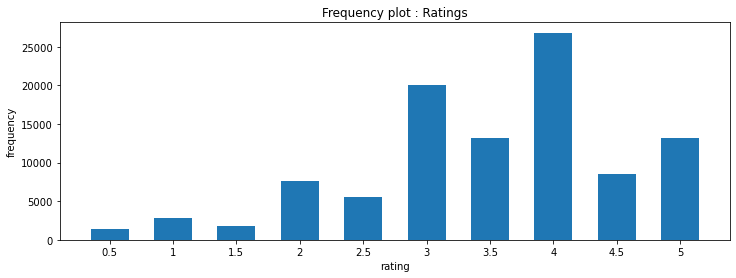

In [11]:
# histogram: frequency of the ratings value
ticks = [ '0.5','1','1.5', '2','2.5','3', '3.5','4', '4.5','5']
plt.figure(figsize=(12,4))
plt.bar(ticks, freq, width = 0.6)
plt.xlabel('rating')
plt.ylabel('frequency')
plt.title("Frequency plot : Ratings")
# plt.grid('True')
plt.savefig('./plots_lib/1B.png')

The rating values first increase and has a peak at 4 and then declines. It is almost like a bell curve with most movies being rated in the range [3,4]. It suggests that few movies are rated at extreme rating values. Further, the plot is right skewed, there are fewer movies which are rated low compared to those rated high. Few movies are rated below 2.5.

#### C. Plot the distribution of the number of ratings received among movies:

In [12]:
a = ratings['movieId'].value_counts().rename_axis('movieId').reset_index(name='count_ratings')
a = a.sort_values('count_ratings', ascending = False)

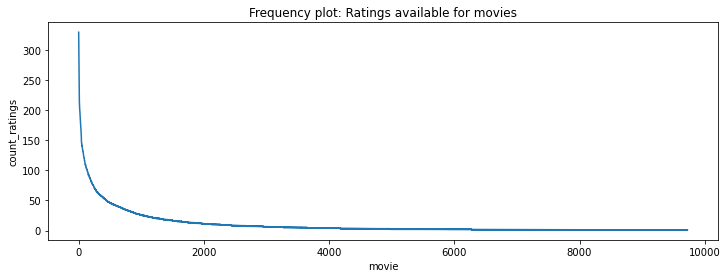

In [13]:
# histogram: number of ratings available for movies
plt.figure(figsize=(12,4))
count_ratings = pd.Series(a['count_ratings'])
  
count_ratings.plot()
plt.xlabel('movie')
plt.ylabel('count_ratings')
plt.title("Frequency plot: Ratings available for movies")
# plt.grid('True')
plt.savefig('./plots_lib/1C.png')

#### D. Plot the distribution of ratings among users

In [14]:
a = ratings['userId'].value_counts().rename_axis('userId').reset_index(name='count_ratings')
a = a.sort_values('count_ratings', ascending = False)

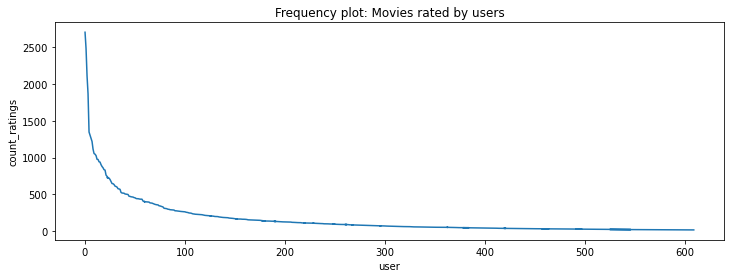

In [15]:
plt.figure(figsize=(12,4))
count_ratings = pd.Series(a['count_ratings'])
  
count_ratings.plot()
plt.xlabel('user')
plt.ylabel('count_ratings')
plt.title("Frequency plot: Movies rated by users")
plt.savefig('./plots_lib/1D.png')

#### E. Discuss the salient features of the distributions <br>

From plot in **part C** above, we see that out of the total ~10,000 movies, only about 2000 movies have ratings from higher than 50 users. There is a long right tail which means that for a majority of the movies there are ratings available from only few users. Also, there is a very steep decline observed suggesting very few movies have high number of ratings. <br>

Similar trend is observed in **part D**, where only about 100 users have rated upto 500 movies, beyond which there is a long right tail suggesting only few movies being rated by a majority of the users. The decline in this plot is less steep compared to the movies plot but still still steep suggesting only a few users have rated significantly high number of movies.  <br>

#### F.  Compute the variance of the rating values received by each movie

Using unbiased sample variance to get the variance for each movie, the formula is <br>
$\frac{1}{(n-1)}\sum_{i=1}^{n}(Y_i - \bar{Y})^2$

In [16]:
## Implementation could be better.
def get_var(m, count):
    if count == 1:
        return 0
    else:
        return m/(count-1)

a = ratings['movieId'].value_counts().rename_axis('movieId').reset_index(name='count_ratings')
b = ratings.groupby(['movieId'])['rating'].mean().reset_index(name = 'mean_rating')

ratings_temp = pd.merge(ratings, b, how = 'left', on = 'movieId')
ratings_temp['xi_xbar_sq'] = ratings_temp.apply(lambda row: ((row['rating']-row['mean_rating'])**2), axis = 1)

c = ratings_temp.groupby(['movieId'])['xi_xbar_sq'].sum().reset_index(name = 'sum_xi_xbar_sq')
d = pd.merge(a, c, how = 'left', on = 'movieId')
d['var'] = d.apply(lambda row: get_var(row['sum_xi_xbar_sq'], row['count_ratings']), axis = 1)


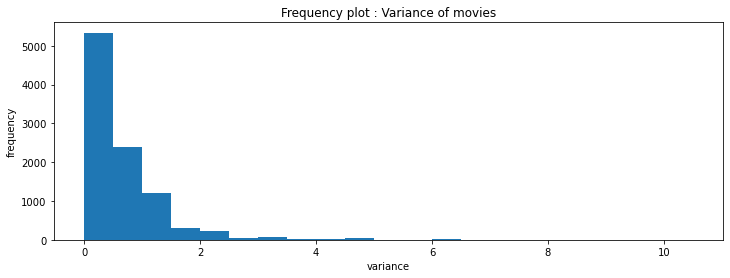

In [17]:
bins = np.arange(min(d['var']), max(d['var'])+0.5, 0.5)
plt.figure(figsize=(12,4))
plt.hist(d['var'], bins = bins)
plt.xlabel('variance')
plt.ylabel('frequency')
plt.title("Frequency plot : Variance of movies")
plt.savefig('./plots_lib/1F.png')

In [18]:
## number of movies with 1 rating
a = ratings['movieId'].value_counts().rename_axis('movieId').reset_index(name='count_ratings')
print(len(a[a['count_ratings'] == 1]))

3446


From the plot above, we observe that majority of movies have very low variance and only few movies have variance $>$ 2. The plot (frequency values) is almost monotonic decreasing in variance with few outlier movies having high variance. The large peak observed at the beginning is because of the long right tail where only 1 rating is available for ~3500 movies leading to 0 variance. The plot suggests that users generally rate a movie with similar rating values.


### QUESTION 2

#### A. Formula for $\mu_u$  <br>

$\mu_u = \dfrac{\sum_{k=1}^{m} r_{uk}}{|I_u|} $ where, $|I_u|$ is the number of items in the set $I_u$, $m$ is the total number of movies rated by the user $u$ and $r_{uk}$ is the rating by the user $u$ to the movie $k$. <br>

#### B. Meaning of $I_u \cap I_v$   <br>

$I_u \cap I_v$ gives the set of movie indices rated by user $u$ as well as rated by user $v$. $I_u \cap I_v$ can be equal to $\emptyset$ when there is no common movie that is rated by both user $u$ and user $v$. <br>

### QUESTION 3

The reason behind mean centering is to remove the user level biases. Each user has a different distribution for rating the movies. So, we care about how much did the current movie rating deviate from the general rating the user provides and use that. For example, person A might in general rate the movies along 1-3, person B might generally rate movies along 4-5. These 2 users might still be rating the movies with the same order and similar difference in ratings if we adjust for their mean preferences. Hence, mean centering is used. <br>

Users generally rate movies around an average value with some variation around that average to denote whether they liked the movie or disliked it. This is being captured when we only look for deviation from the mean to get whether the similar user liked the movie or not and then adjust the user's rating with respect to their mean accordingly. <br>

### QUESTION 4

http://surpriselib.com/

In [19]:
## cross-validate on 10 folds and compare results

reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

cv = 10
sim_options = {'name': 'pearson'}
kf = KFold(n_splits=cv, random_state = 42)

In [20]:
start_time = time.time()

rmse_results = {}
mae_results = {}

for k in range(2, 101, 2):
    algo = KNNWithMeans(k = k, sim_options=sim_options, verbose = False, random_state = 42)
    a = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=cv)
    rmse_results[k] = sum(a['test_rmse'])/cv
    mae_results[k] = sum(a['test_mae'])/cv
    
print("done in %0.3fs." % (time.time() - start_time))  # 560.493

done in 597.513s.


In [21]:
def plot_k (k_dict, y, text, x_label,y_label,title,name ):
    results = pd.DataFrame.from_dict(k_dict, orient='index')
    results = results.reset_index()
    results.columns = ['k', y]

    print(text)
    plt.figure(figsize=(12,4))
    plt.plot(results['k'], results[y])
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.savefig('./plots_lib/'+name+'.png')

Plotting average cross validation error(RMSE) for different number of neighbors with KNN:


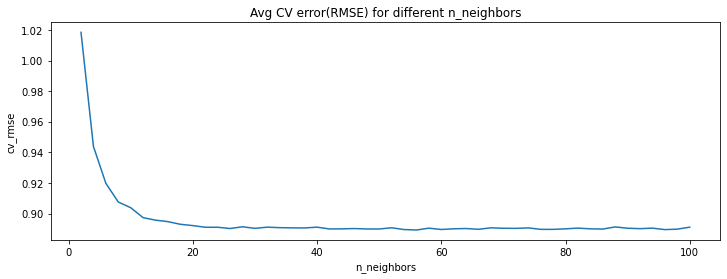

In [22]:
plot_k(rmse_results, 'rmse', \
       text = "Plotting average cross validation error(RMSE) for different number of neighbors with KNN:", \
      x_label = 'n_neighbors', y_label = 'cv_rmse', title = 'Avg CV error(RMSE) for different n_neighbors', \
      name = '4A')

Plotting average cross validation error(MAE) for different number of neighbors with KNN:


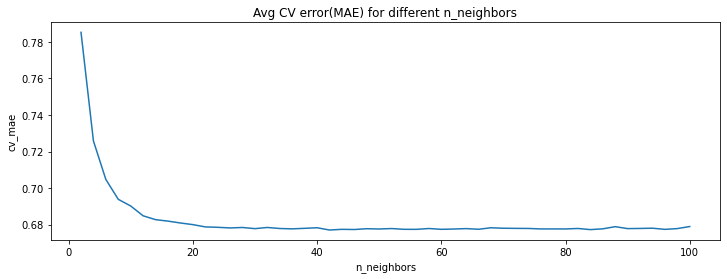

In [23]:
plot_k(mae_results, 'mae', \
       text = "Plotting average cross validation error(MAE) for different number of neighbors with KNN:", \
      x_label = 'n_neighbors', y_label = 'cv_mae', title = 'Avg CV error(MAE) for different n_neighbors', \
      name = '4B')

In [24]:
results_rmse = pd.DataFrame.from_dict(rmse_results, orient='index')
results_rmse = results_rmse.reset_index()
results_rmse.columns = ['k', 'rmse']

results_mae = pd.DataFrame.from_dict(mae_results, orient='index')
results_mae = results_mae.reset_index()
results_mae.columns = ['k', 'mae']

results = pd.merge(results_rmse, results_mae, how = 'left', on = 'k')

In [25]:
# results

### QUESTION 5

From the plots above, we observe that increasing k beyond k = 20 does not result in a significant decrease in RMSE or MAE. There is a steep decline in both RMSE and MAE as we increase the number of neighbors initially. However, it saturates to a steady state value after a certain n_neighbors. Both the plots for RMSE as well as MAE become flat at around k = 20. The steady state values for k = 20 are: <br>

In [26]:
best_k = 20

In [27]:
print("Value for RMSE at k = ", best_k," is: ", results_rmse[results_rmse['k']== best_k]['rmse'].iloc[0])

Value for RMSE at k =  20  is:  0.8921475165929152


In [28]:
print("Value for MAE at k = ", best_k," is: ", results_mae[results_mae['k']== best_k]['mae'].iloc[0])

Value for MAE at k =  20  is:  0.6800439942186892


### QUESTION 6

In [29]:
# popular and unpopular movie trimming
unpopular_movies = ratings.groupby(['movieId']).size().reset_index(name = 'num_ratings')
unpopular_movies = unpopular_movies[unpopular_movies['num_ratings'] <= 2]
unpopular_movies = list(set(unpopular_movies['movieId']))
# keep movies in the testset when movie is not in unpopular_movies

# High variance trimming
def get_var(m, count):
    if count == 1:
        return 0
    else:
        return m/(count-1)

a = ratings['movieId'].value_counts().rename_axis('movieId').reset_index(name='count_ratings')
b = ratings.groupby(['movieId'])['rating'].mean().reset_index(name = 'mean_rating')

ratings_temp = pd.merge(ratings, b, how = 'left', on = 'movieId')
ratings_temp['xi_xbar_sq'] = ratings_temp.apply(lambda row: ((row['rating']-row['mean_rating'])**2), axis = 1)

c = ratings_temp.groupby(['movieId'])['xi_xbar_sq'].sum().reset_index(name = 'sum_xi_xbar_sq')
d = pd.merge(a, c, how = 'left', on = 'movieId')
d['var'] = d.apply(lambda row: get_var(row['sum_xi_xbar_sq'], row['count_ratings']), axis = 1)
var_trim = d[~((d['var'] < 2) | (d['count_ratings'] < 5))]
var_trim = list(set(var_trim['movieId']))


In [30]:
print("Total movies with popular movie trimming: ", a.shape[0] - len(unpopular_movies))
print("Total movies with unpopular movie trimming: ", len(unpopular_movies))
print("Total movies with high variance movie trimming: ",len(var_trim))

Total movies with popular movie trimming:  4980
Total movies with unpopular movie trimming:  4744
Total movies with high variance movie trimming:  88


In [31]:
def change_was_impossible_pred (predictions, usr_mean_dict, trainset):
    for i in range(len(predictions)):
        if(predictions[i].details['was_impossible']):
            try:
                val = usr_mean_dict[trainset.to_inner_uid(predictions[i].uid)]
                predictions[i] = predictions[i]._replace(est=val)
            except:
                "Nothing"
    return predictions

In [32]:
start_time = time.time()

cv = 10
kf = KFold(n_splits=cv)

sim_options = {'name': 'pearson'}

rmse_pop_trim_results = {}
rmse_unpop_trim_results = {}
rmse_var_trim_results = {}
# test set is a list of tuples of the form (userid, movieid, rating)

for k in range(2, 101, 2):
    algo = KNNWithMeans(k = k, sim_options=sim_options, verbose = False, random_state = 42)
    rmse_pop_trim_k = 0
    rmse_unpop_trim_k = 0
    rmse_var_trim_k = 0
    for trainset, testset in kf.split(data):   
        algo.fit(trainset)
        
        # popular movie trimming
        testset_pop_movie_trim = [test for test in testset \
                                  if test[1] not in unpopular_movies]
        predictions_pop_movies = algo.test(testset_pop_movie_trim)
        rmse_pop_trim_k = rmse_pop_trim_k + accuracy.rmse(predictions_pop_movies, verbose = False)
        
        # unpopular movie trimming
        testset_unpop_movie_trim = [test for test in testset \
                                  if test[1] in unpopular_movies]
        predictions_unpop_movies = algo.test(testset_unpop_movie_trim)
        rmse_unpop_trim_k = rmse_unpop_trim_k + accuracy.rmse(predictions_unpop_movies, verbose = False)
        
        # high var trimming
        testset_high_var_trim = [test for test in testset \
                                  if test[1] in var_trim]
        predictions_high_var_trim = algo.test(testset_high_var_trim)
        rmse_var_trim_k = rmse_var_trim_k + accuracy.rmse(predictions_high_var_trim, verbose = False)
        
        
    rmse_pop_trim_results[k] = rmse_pop_trim_k/cv
    rmse_unpop_trim_results[k] = rmse_unpop_trim_k/cv
    rmse_var_trim_results[k] = rmse_var_trim_k/cv
        
print("done in %0.3fs." % (time.time() - start_time)) 

done in 1125.152s.


For popular movie trimming in testset:
Plotting average cross validation error(RMSE) for different number of neighbors with KNN with popular movie trimming:
Minimum RMSE is:  0.8712441072583852 achieved at k =  [54]


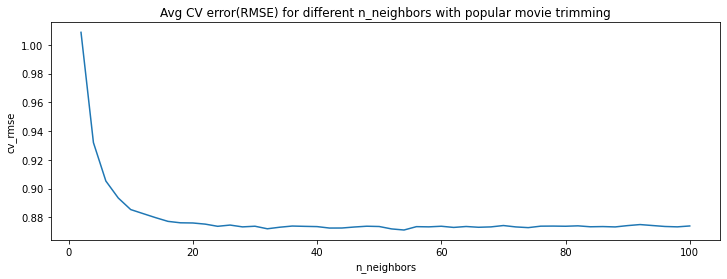

In [33]:
print("For popular movie trimming in testset:")
plot_k(rmse_pop_trim_results, 'rmse', \
       text = "Plotting average cross validation error(RMSE) for different number of neighbors with KNN with popular movie trimming:", \
      x_label = 'n_neighbors', y_label = 'cv_rmse', title = 'Avg CV error(RMSE) for different n_neighbors with popular movie trimming', \
      name = '6A')

min_rmse = min(rmse_pop_trim_results.values())
key = [key for key in rmse_pop_trim_results if rmse_pop_trim_results[key] == min_rmse]
  
print("Minimum RMSE is: ", str(min_rmse), 'achieved at k = ', str(key))


For unpopular movie trimming in testset:
Plotting average cross validation error(RMSE) for different number of neighbors with KNN with unpopular movie trimming:
Minimum RMSE is:  1.1097085133486644 achieved at k =  [42]


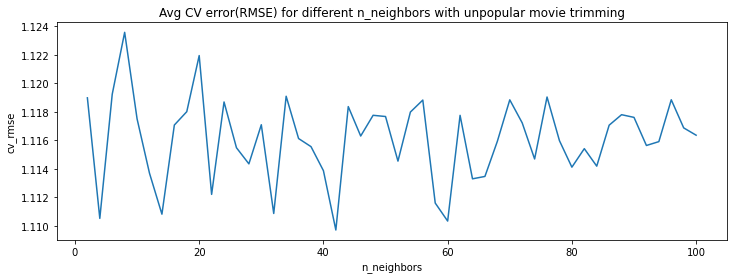

In [34]:
print("For unpopular movie trimming in testset:")
plot_k(rmse_unpop_trim_results, 'rmse', \
       text = "Plotting average cross validation error(RMSE) for different number of neighbors with KNN with unpopular movie trimming:", \
      x_label = 'n_neighbors', y_label = 'cv_rmse', title = 'Avg CV error(RMSE) for different n_neighbors with unpopular movie trimming', \
      name = '6B')

min_rmse = min(rmse_unpop_trim_results.values())
key = [key for key in rmse_unpop_trim_results if rmse_unpop_trim_results[key] == min_rmse]
  
print("Minimum RMSE is: ", str(min_rmse), 'achieved at k = ', str(key))

For high variance movie trimming in testset:
Plotting average cross validation error(RMSE) for different number of neighbors with KNN with high variance movie trimming:
Minimum RMSE is:  1.4182685976308722 achieved at k =  [44]


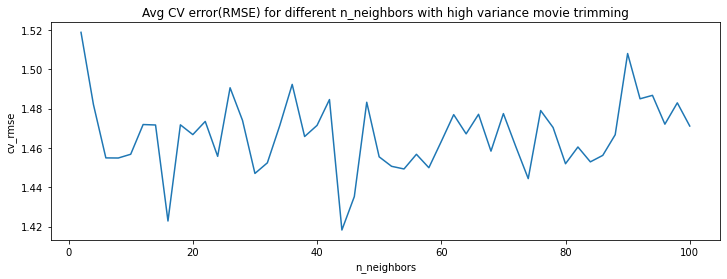

In [35]:
print("For high variance movie trimming in testset:")
plot_k(rmse_var_trim_results, 'rmse', \
       text = "Plotting average cross validation error(RMSE) for different number of neighbors with KNN with high variance movie trimming:", \
      x_label = 'n_neighbors', y_label = 'cv_rmse', title = 'Avg CV error(RMSE) for different n_neighbors with high variance movie trimming', \
      name = '6C')

min_rmse = min(rmse_var_trim_results.values())
key = [key for key in rmse_var_trim_results if rmse_var_trim_results[key] == min_rmse]
  
print("Minimum RMSE is: ", str(min_rmse), 'achieved at k = ', str(key))

#### roc curve 

In [36]:
def plot_ROC(fpr,tpr, plot_name, trimming, threshold):
    fig = plt.figure()
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr,tpr,label="area under curve = %0.3f" %roc_auc)
    plt.title('ROC curve with trimming '+str(trimming)+' and threshold '+str(threshold))
    plt.xlabel('False positive rate',fontsize=10)
    plt.ylabel('True positive rate',fontsize=10)
    plt.grid()
    plt.legend()
    plt.savefig('./plots_lib/plot'+plot_name+'.png')
    return roc_auc

In [37]:
def roc_plots(predictions, threshold_list, name1, name2):
    pred = np.array([p.est for p in predictions])
    actual = np.array([p.r_ui for p in predictions])

    for threshold in threshold_list:
        y_pred = pred
        y_act = actual>=threshold
        fpr, tpr, _ = roc_curve(y_act, y_pred )
        roc_auc = auc(fpr, tpr)
        plot_ROC(fpr,tpr, 'pl'+str(name1)+'_'+str(threshold), name2, threshold)

In [38]:
threshold_list = [2.5,3,3.5,4]
trainset, testset = train_test_split(data, test_size=0.1, random_state=0)

k = best_k
algo = algo = KNNWithMeans(k = k, sim_options=sim_options, verbose = False)
algo.fit(trainset)

For no trimming: 


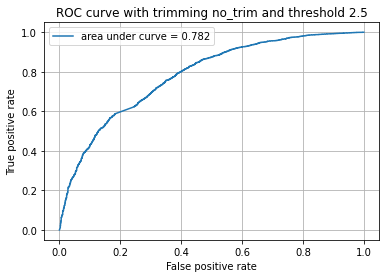

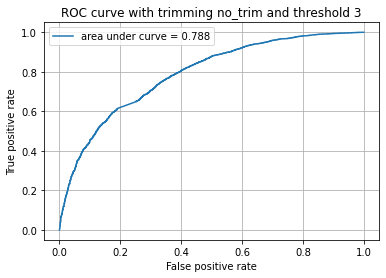

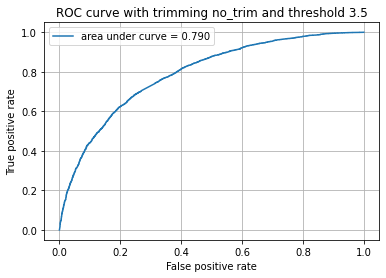

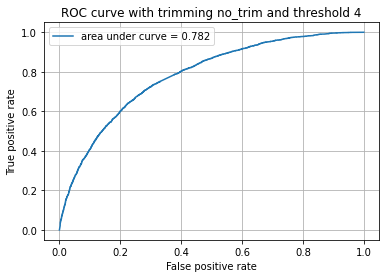

In [39]:
print("For no trimming: ")
predictions = algo.test(testset)
roc_plots(predictions, threshold_list, '6D_roc_no_trim_', 'no_trim')

For popular movie trimming in testset:


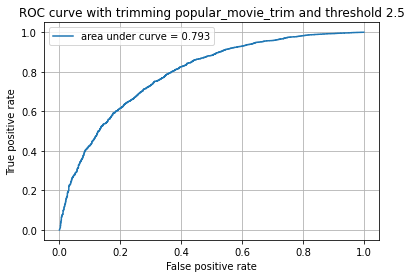

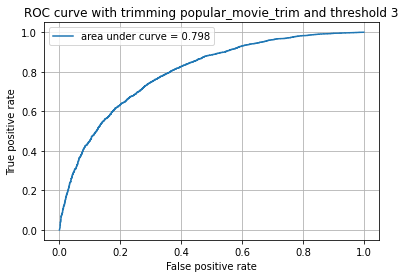

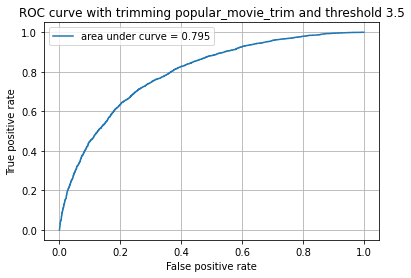

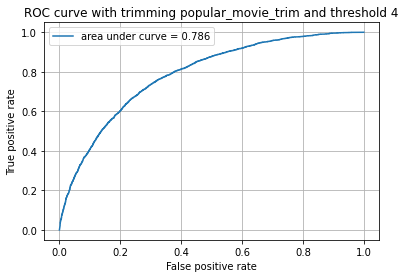

In [40]:
print("For popular movie trimming in testset:")
testset_pop_movie_trim = [test for test in testset \
                                  if test[1] not in unpopular_movies]

predictions = algo.test(testset_pop_movie_trim)
roc_plots(predictions, threshold_list, '6D_roc_pop_trim_', 'popular_movie_trim')

For unpopular movie trimming in testset:


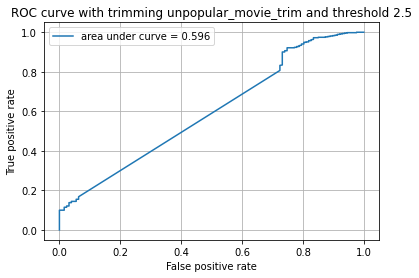

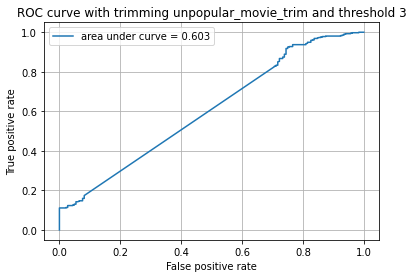

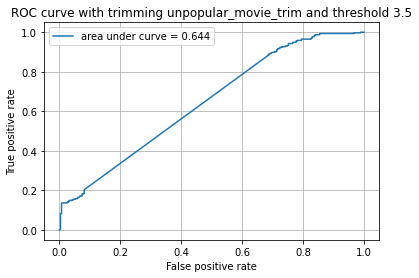

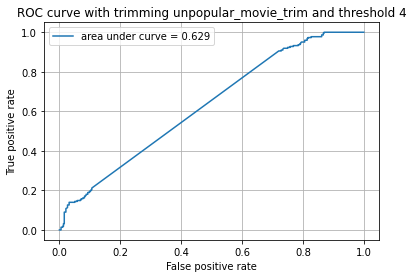

In [41]:
print("For unpopular movie trimming in testset:")
testset_unpop_movie_trim = [test for test in testset \
                                  if test[1] in unpopular_movies]

predictions = algo.test(testset_unpop_movie_trim)
roc_plots(predictions, threshold_list, '6D_roc_unpop_trim_', 'unpopular_movie_trim')

For high variance movie trimming in testset:


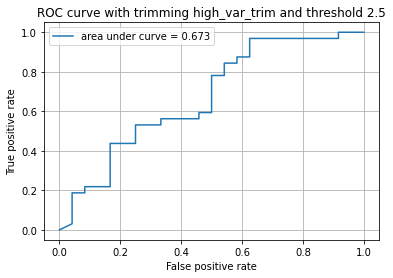

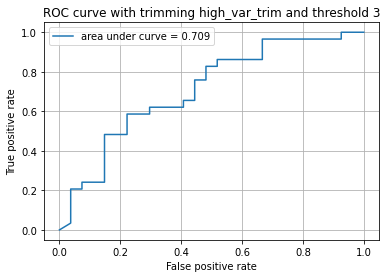

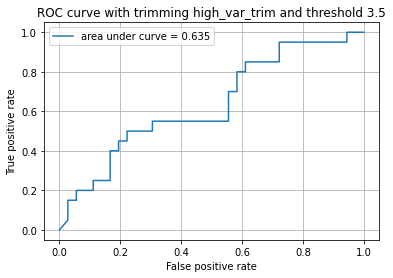

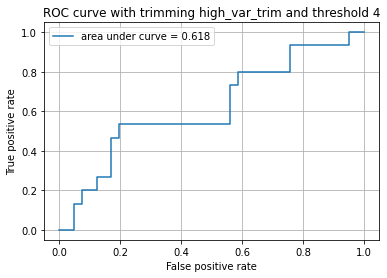

In [42]:
print("For high variance movie trimming in testset:")
testset_high_var_trim = [test for test in testset \
                                  if test[1] in var_trim]

predictions = algo.test(testset_high_var_trim)
roc_plots(predictions, threshold_list, '6D_roc_high_var_trim_', 'high_var_trim')

The popular movies perform similar to the base model. However, the model for unpopular movies and high variance movies do not perform very well with the KNN method. There are only 88 movies with high variance. For unpopular movies which have at max 2 users rating the movie, for any user in the test set there can be at max 1 other user in the train set which can be used to predict the rating. Hence, unpopular movies behave erratically.  <br>

### QUESTION 7 <br>

The general optimization problem given by Equation 5 is not necessarily a convex optimization problem. Convex matrix factorization restricts the columns of $U$ to be convex combinations of the data vectors in ratings matrix R. <br>

The optimization function is given by <br>
$\sum_{i=1}^{n} \sum_{j=1}^{m} W_{ij} (r_{ij} - (UV^T)_{ij})^2 $ where n is the total number of users and m is the total number of movies. Now, let us define $u_{i}$ as the ith row of the matrix $U$ and $v_{j}^T$ as the jth column of the matrix $V$. <br>

Given the above, we can separate the dataset by movie to get the estimates for each column $v_{j}^T$. Then we have m optimization problems of the form: <br>
$\sum_{i=1}^{n} W_{ij} (r_{ij} - u_{i} v_{j}^T)^2 $ where $u_{i}$ can be paralleled to x or the independent variables and elements of $v_{j}^T$ can be paralleled to parameters $\theta$ giving a least squares problem. The vector $r_{ij}$ is the dependent variable $y$. Each of the above can be minimized to get the latent vector for movie $j$. Together, all the latent vectors would make the estimated matrix $V$. <br>



### QUESTION 8

#### Recommender system using matrix factorization - NMF

In [43]:
start_time = time.time()

cv = 10
kf = KFold(n_splits=cv, random_state = 42)

rmse_results = {}
mae_results = {}

for k in range(2, 51, 2):
    algo = NMF(n_factors = k, random_state = 42)
    a = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=cv)
    rmse_results[k] = sum(a['test_rmse'])/cv
    mae_results[k] = sum(a['test_mae'])/cv
    
print("done in %0.3fs." % (time.time() - start_time))


done in 1777.136s.


Plotting average cross validation error(RMSE) for different number of neighbors with NMF:
Minimum RMSE is:  0.9129118066799382 achieved at k =  [16]


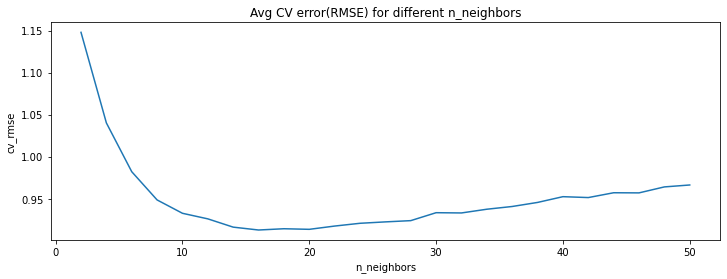

In [44]:
plot_k(rmse_results, 'rmse', \
       text = "Plotting average cross validation error(RMSE) for different number of neighbors with NMF:", \
      x_label = 'n_neighbors', y_label = 'cv_rmse', title = 'Avg CV error(RMSE) for different n_neighbors', \
      name = '8A')

min_rmse = min(rmse_results.values())
key = [key for key in rmse_results if rmse_results[key] == min_rmse]
  
print("Minimum RMSE is: ", str(min_rmse), 'achieved at k = ', str(key))

Plotting average cross validation error(MAE) for different number of neighbors with NMF:
Minimum MAE is:  0.6933536073456911 achieved at k =  [20]


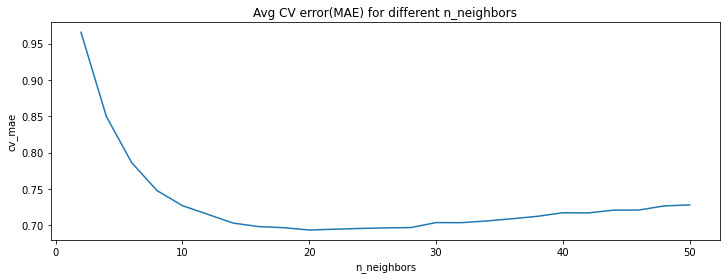

In [45]:
plot_k(mae_results, 'mae', \
       text = "Plotting average cross validation error(MAE) for different number of neighbors with NMF:", \
      x_label = 'n_neighbors', y_label = 'cv_mae', title = 'Avg CV error(MAE) for different n_neighbors', \
      name = '8B')

min_mae = min(mae_results.values())
key = [key for key in mae_results if mae_results[key] == min_mae]
  
print("Minimum MAE is: ", str(min_mae), 'achieved at k = ', str(key))

**B:** 

From the graphs for RMSE and MAE, the minimum values for RMSE and MAE are obtained at 16 and 20 n_latent_factors respectively. The error metrics first declines as we increase the number of latent factors and then increases again after attaining a minimum value. The `best_k` is chosen to be 20 where MAE attains the minimum value.

In [46]:
best_k = 20

In [47]:
min_rmse = min(rmse_results.values())
key = [key for key in rmse_results if rmse_results[key] == min_rmse]
print("Minimum RMSE is: ", str(min_rmse), 'achieved at k = ', str(key))

Minimum RMSE is:  0.9129118066799382 achieved at k =  [16]


In [48]:
min_mae = min(mae_results.values())
key = [key for key in mae_results if mae_results[key] == min_mae]
print("Minimum MAE is: ", str(min_mae), 'achieved at k = ', str(key))

Minimum MAE is:  0.6933536073456911 achieved at k =  [20]


In [49]:
print("Value for RMSE at best_k = ", best_k," is: ", rmse_results[best_k])

Value for RMSE at best_k =  20  is:  0.9137220315520898


In [50]:
print("Value for MAE at best_k = ", best_k," is: ", mae_results[best_k])

Value for MAE at best_k =  20  is:  0.6933536073456911


In [51]:
genres = list(set(movies['genres']))

genre_list = []
for genre in genres:
    all_genre = genre.split('|')
    genre_list.extend(all_genre)

genre_list_all = list(set(genre_list))

print("List of genre: ", genre_list_all)
print("Total unique genres in list of genre: ", len(genre_list_all))

List of genre:  ['Animation', 'Thriller', 'Comedy', 'Film-Noir', 'Drama', 'Crime', 'Musical', 'IMAX', '(no genres listed)', 'Sci-Fi', 'Adventure', 'Action', 'Horror', 'Children', 'Western', 'Romance', 'War', 'Fantasy', 'Mystery', 'Documentary']
Total unique genres in list of genre:  20


The optimal number of latent factors are around the total number of movie genres. However, not considering (no genres listed) as a movie genre, we can infer that the number of latent factors is not equal to the number of genre. We do not expect latent factors to capture a 1 to 1 correlation with movie genre.

**C: Performance on trimmed test sets** 

In [52]:
start_time = time.time()

cv = 10
kf = KFold(n_splits=cv, random_state = 42)

sim_options = {'name': 'pearson'}

rmse_pop_trim_results = {}
rmse_unpop_trim_results = {}
rmse_var_trim_results = {}
# test set is a list of tuples of the form (userid, movieid, rating)

# can we make this more efficient
for k in range(2, 51, 2):
    algo = NMF(n_factors = k, random_state = 42)
    rmse_pop_trim_k = 0
    rmse_unpop_trim_k = 0
    rmse_var_trim_k = 0
    for trainset, testset in kf.split(data):   
        algo.fit(trainset)
        
        # popular movie trimming
        testset_pop_movie_trim = [test for test in testset \
                                  if test[1] not in unpopular_movies]
        predictions_pop_movies = algo.test(testset_pop_movie_trim)
        rmse_pop_trim_k = rmse_pop_trim_k + accuracy.rmse(predictions_pop_movies, verbose = False)
        
        # unpopular movie trimming
        testset_unpop_movie_trim = [test for test in testset \
                                  if test[1] in unpopular_movies]
        predictions_unpop_movies = algo.test(testset_unpop_movie_trim)
        rmse_unpop_trim_k = rmse_unpop_trim_k + accuracy.rmse(predictions_unpop_movies, verbose = False)
        
        # high var trimming
        testset_high_var_trim = [test for test in testset \
                                  if test[1] in var_trim]
        predictions_high_var_trim = algo.test(testset_high_var_trim)
        rmse_var_trim_k = rmse_var_trim_k + accuracy.rmse(predictions_high_var_trim, verbose = False)
        
        
    rmse_pop_trim_results[k] = rmse_pop_trim_k/cv
    rmse_unpop_trim_results[k] = rmse_unpop_trim_k/cv
    rmse_var_trim_results[k] = rmse_var_trim_k/cv
        
print("done in %0.3fs." % (time.time() - start_time)) 

done in 1945.257s.


For popular movie trimming in testset:
Plotting average cross validation error(RMSE) for different number of neighbors with NMF with popular movie trimming:
Minimum RMSE is:  0.8924565686522052 achieved at k =  [16]


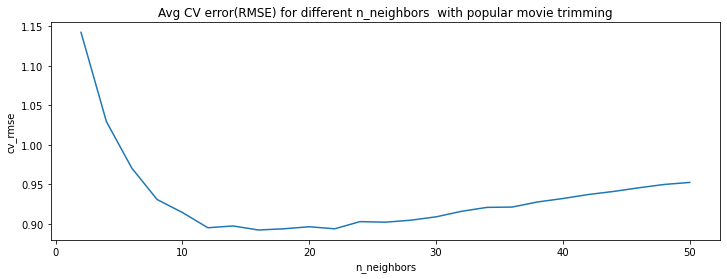

In [53]:
print("For popular movie trimming in testset:")
plot_k(rmse_pop_trim_results, 'rmse', \
       text = "Plotting average cross validation error(RMSE) for different number of neighbors with NMF with popular movie trimming:", \
      x_label = 'n_neighbors', y_label = 'cv_rmse', title = 'Avg CV error(RMSE) for different n_neighbors  with popular movie trimming', \
      name = '8C')

min_rmse = min(rmse_pop_trim_results.values())
key = [key for key in rmse_pop_trim_results if rmse_pop_trim_results[key] == min_rmse]
  
print("Minimum RMSE is: ", str(min_rmse), 'achieved at k = ', str(key))


Plotting average cross validation error(RMSE) for different number of neighbors with NMF with unpopular movie trimming:
Minimum RMSE is:  1.1741755766289237 achieved at k =  [48]


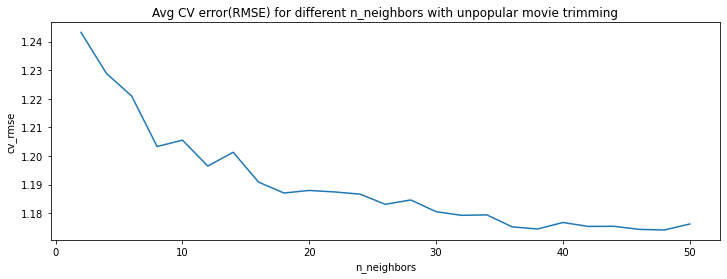

In [54]:
plot_k(rmse_unpop_trim_results, 'rmse', \
       text = "Plotting average cross validation error(RMSE) for different number of neighbors with NMF with unpopular movie trimming:", \
      x_label = 'n_neighbors', y_label = 'cv_rmse', title = 'Avg CV error(RMSE) for different n_neighbors with unpopular movie trimming', \
      name = '8D')

min_rmse = min(rmse_unpop_trim_results.values())
key = [key for key in rmse_unpop_trim_results if rmse_unpop_trim_results[key] == min_rmse]
  
print("Minimum RMSE is: ", str(min_rmse), 'achieved at k = ', str(key))

Plotting average cross validation error(RMSE) for different number of neighbors with NMF with high variance movie trimming:
Minimum RMSE is:  1.460444435539621 achieved at k =  [12]


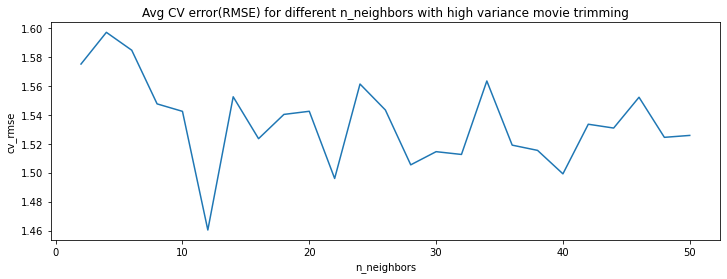

In [55]:
plot_k(rmse_var_trim_results, 'rmse', \
       text = "Plotting average cross validation error(RMSE) for different number of neighbors with NMF with high variance movie trimming:", \
      x_label = 'n_neighbors', y_label = 'cv_rmse', title = 'Avg CV error(RMSE) for different n_neighbors with high variance movie trimming', \
      name = '8E')

min_rmse = min(rmse_var_trim_results.values())
key = [key for key in rmse_var_trim_results if rmse_var_trim_results[key] == min_rmse]
  
print("Minimum RMSE is: ", str(min_rmse), 'achieved at k = ', str(key))

#### roc curve 

In [56]:
threshold_list = [2.5,3,3.5,4]

trainset, testset = train_test_split(data, test_size=0.1, random_state=0)
algo = NMF(n_factors = best_k, random_state = 42)
algo.fit(trainset)

For no trimming: 


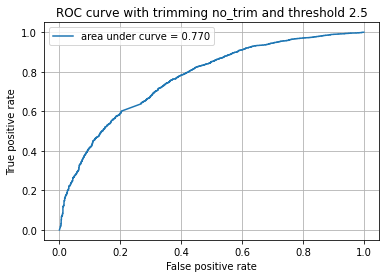

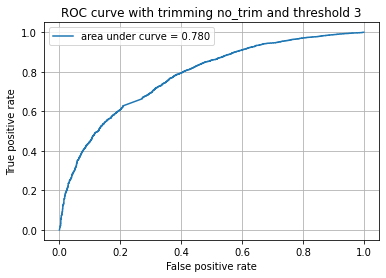

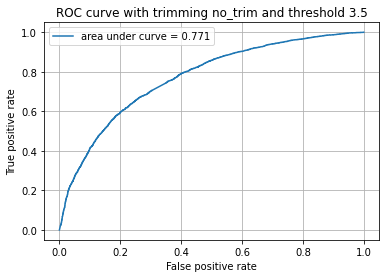

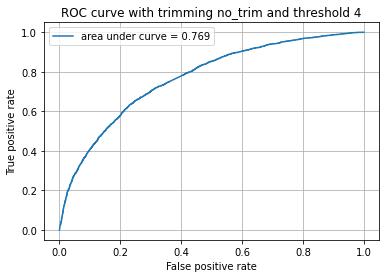

In [57]:
print("For no trimming: ")
predictions = algo.test(testset)
roc_plots(predictions, threshold_list, '8F_roc_no_trim_', 'no_trim')

For popular movie trimming in testset:


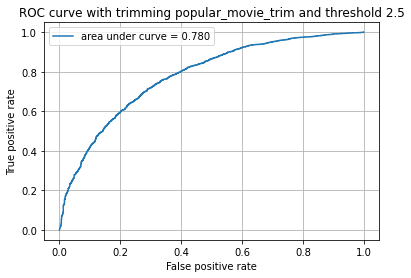

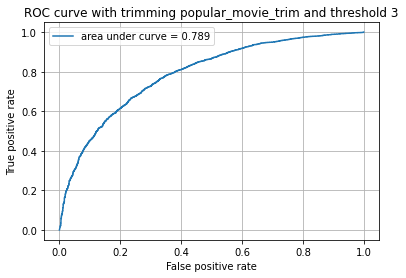

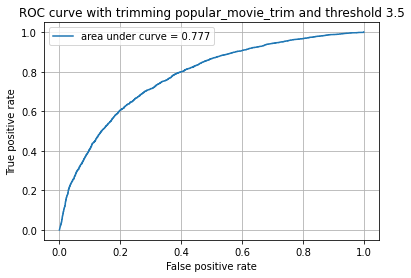

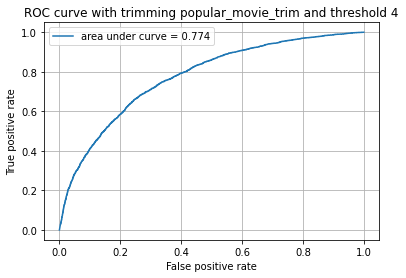

In [58]:
print("For popular movie trimming in testset:")
testset_pop_movie_trim = [test for test in testset \
                                  if test[1] not in unpopular_movies]

predictions = algo.test(testset_pop_movie_trim)
roc_plots(predictions, threshold_list, '8F_roc_pop_trim_', 'popular_movie_trim')

For unpopular movie trimming in testset:


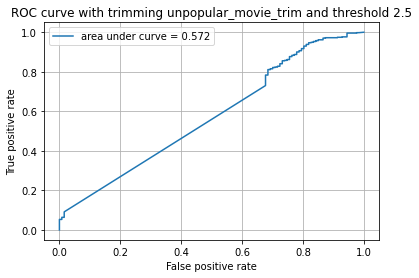

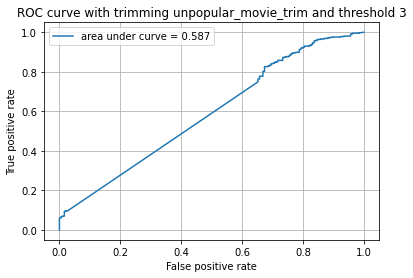

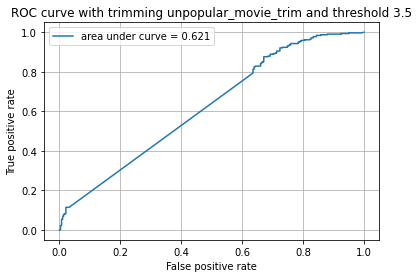

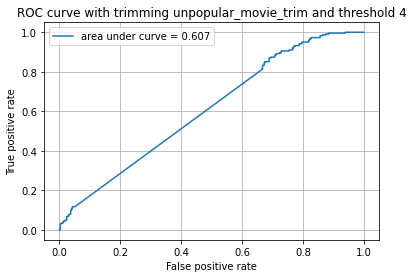

In [59]:
print("For unpopular movie trimming in testset:")
testset_unpop_movie_trim = [test for test in testset \
                                  if test[1] in unpopular_movies]

predictions = algo.test(testset_unpop_movie_trim)
roc_plots(predictions, threshold_list, '8F_roc_unpop_trim_', 'unpopular_movie_trim')

For high variance movie trimming in testset:


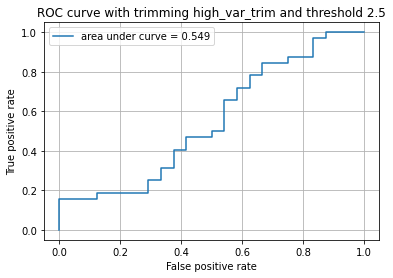

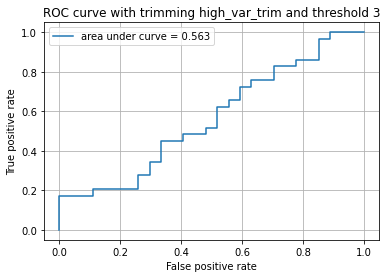

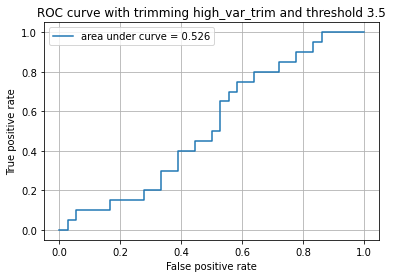

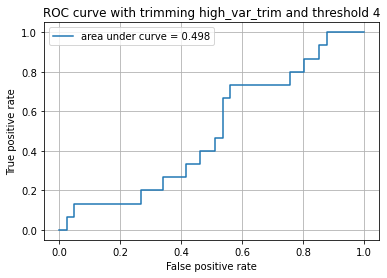

In [60]:
print("For high variance movie trimming in testset:")
testset_high_var_trim = [test for test in testset \
                                  if test[1] in var_trim]

predictions = algo.test(testset_high_var_trim)
roc_plots(predictions, threshold_list, '8F_roc_high_var_trim_', 'high_var_trim')

### QUESTION 9

In [61]:
algo = NMF(n_factors = best_k, random_state = 42)
trainset=data.build_full_trainset()

algo.fit(trainset)

u = algo.pu
v = algo.qi

In [62]:
v.shape

(9724, 20)

In [63]:
all_genres = {}
all_movies = {}
for i in range(best_k):
    v_i = v[:,i]

    top_10_idx = np.argsort(v_i)[-10:][::-1]
    top_10_movies = []
    top_10_genre = []
    for inner_id in top_10_idx:
        
        movie_id = trainset.to_raw_iid(inner_id)
        top_10_movies.append(movie_id)
        top_10_genre.append(movies[movies['movieId'] == movie_id]['genres'].iloc[0])
        all_genres[i] = top_10_genre
        all_movies[i] = top_10_movies
        


In [64]:
print("Genre for top movies in each latent factor: ")
for i in range(best_k):
    print("Genre for top 10 movies corresponding to latent factor: ", str(i))
    print(all_genres[i])
    print('')

Genre for top movies in each latent factor: 
Genre for top 10 movies corresponding to latent factor:  0
['Fantasy|Horror', 'Horror|Mystery|Thriller', 'Horror', 'Action|Crime|Thriller', 'Drama|Thriller', 'Drama|Horror|Thriller', 'Drama', 'Comedy|Drama', 'Action|Adventure', 'Crime|Horror|Mystery']

Genre for top 10 movies corresponding to latent factor:  1
['Children|Comedy', 'Comedy', 'Comedy|Fantasy|Horror', 'Comedy|Romance', 'Adventure|Comedy|Sci-Fi', 'Drama|War', 'Crime|Drama', 'Action|Comedy|Sci-Fi|Thriller', 'Comedy', 'Action|Adventure|Children|Comedy']

Genre for top 10 movies corresponding to latent factor:  2
['Comedy|Drama|Romance', 'Comedy|Crime', 'Action|Sci-Fi|Thriller', 'Documentary', 'Documentary', 'Romance|Thriller', 'Action|Children', 'Comedy', 'Comedy|Romance', 'Drama|War']

Genre for top 10 movies corresponding to latent factor:  3
['Action|Sci-Fi', 'Sci-Fi', 'Horror|Sci-Fi', 'Comedy|Drama', 'Comedy', 'Action|Drama|Fantasy', 'Horror|Sci-Fi', 'Action|Adventure|Animation

In [65]:
genres = list(set(movies['genres']))

genre_list = []
for genre in genres:
    all_genre = genre.split('|')
    genre_list.extend(all_genre)
genres = list(set(genre_list))

In [66]:
from collections import Counter

genre_latent_factor = pd.DataFrame()
for l in range(20):
    a = all_genres[l]
    gen_ls2 = []
    for i in a:
        gen_ls = i.split('|')
        gen_ls2.extend(gen_ls)
    counts = Counter(gen_ls2)
    d1 = pd.DataFrame.from_dict(counts, orient='index').reset_index()
    d1.columns = ['genre', 'count']
    d1['latent_factor'] = l
    genre_latent_factor = pd.concat([genre_latent_factor, d1])
    

In [67]:
df1 = pd.pivot_table(genre_latent_factor, index='genre', columns=['latent_factor'], values='count')

In [68]:
def highlight(cell_value):

    highlight = 'background-color: yellow;'
    default = ''

    if not np.isnan(cell_value):
        if int(cell_value) >= 4 :
            return highlight
    return default



In [69]:
# df1.style
df1.style.set_precision(1).applymap(highlight)

latent_factor,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
genre,,,,,,,,,,,,,,,,,,,,
Action,2.0,2.0,2.0,3.0,2.0,2.0,4.0,2.0,2.0,2.0,3.0,1.0,1.0,1.0,nan,1.0,2.0,3.0,3.0,3.0
Adventure,1.0,2.0,nan,1.0,nan,1.0,1.0,1.0,2.0,2.0,2.0,2.0,nan,2.0,nan,nan,nan,1.0,nan,1.0
Animation,nan,nan,nan,1.0,nan,3.0,1.0,1.0,1.0,nan,nan,1.0,nan,1.0,nan,nan,1.0,nan,nan,nan
Children,nan,2.0,1.0,1.0,nan,3.0,2.0,nan,1.0,3.0,nan,nan,nan,1.0,nan,nan,nan,1.0,nan,nan
Comedy,1.0,8.0,4.0,3.0,4.0,8.0,7.0,4.0,4.0,5.0,1.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,4.0,8.0
Crime,2.0,1.0,1.0,nan,1.0,1.0,2.0,nan,nan,1.0,2.0,1.0,1.0,1.0,1.0,nan,1.0,1.0,nan,nan
Documentary,nan,nan,2.0,nan,1.0,nan,nan,1.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.0,1.0
Drama,4.0,2.0,2.0,4.0,3.0,2.0,3.0,5.0,2.0,3.0,4.0,7.0,5.0,4.0,6.0,7.0,7.0,3.0,6.0,2.0
Fantasy,1.0,1.0,nan,1.0,2.0,nan,2.0,1.0,2.0,3.0,2.0,nan,1.0,1.0,nan,2.0,2.0,nan,nan,1.0


In the above table, the combinations where there are more than 3 out of 10 movies representative of the latent factor belonging to a particular genre is highlighted. We observe that, 'Comedy' and 'Drama' are quite spread out among all the latent factors. Some latent factors are more representative of a particular genre. Like latent factor 19 predominantly has comedy movies, latent factor 16 has predominantly drama movies. Scifi movies belong to latent factor 3 and action movies belong to latent factor 6. <br>

Some genre like IMAX, War, Western do not have enough representation in the top 10 movies for the latent factors. <br>

### QUESTION 10

In [70]:
start_time = time.time()

rmse_results = {}
mae_results = {}

for k in range(2, 51, 2):
    algo = SVD(n_factors = k, n_epochs=50,  random_state=42)
    a = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=cv)
    rmse_results[k] = sum(a['test_rmse'])/cv
    mae_results[k] = sum(a['test_mae'])/cv
    
print("done in %0.3fs." % (time.time() - start_time))


done in 1466.893s.


Plotting average cross validation error(RMSE) for different number of neighbors with MF with bias:
Minimum RMSE is:  0.8630939144585111 achieved at k =  [2]


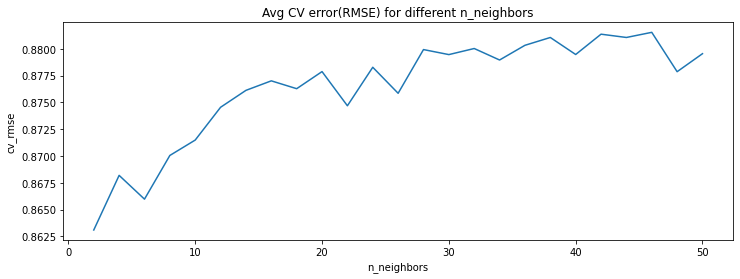

In [71]:
plot_k(rmse_results, 'rmse', \
       text = "Plotting average cross validation error(RMSE) for different number of neighbors with MF with bias:", \
      x_label = 'n_neighbors', y_label = 'cv_rmse', title = 'Avg CV error(RMSE) for different n_neighbors', \
      name = '10A')

min_rmse = min(rmse_results.values())
key = [key for key in rmse_results if rmse_results[key] == min_rmse]
  
print("Minimum RMSE is: ", str(min_rmse), 'achieved at k = ', str(key))

Plotting average cross validation error(MAE) for different number of neighbors with MF with bias:
Minimum MAE is:  0.6597127848546552 achieved at k =  [2]


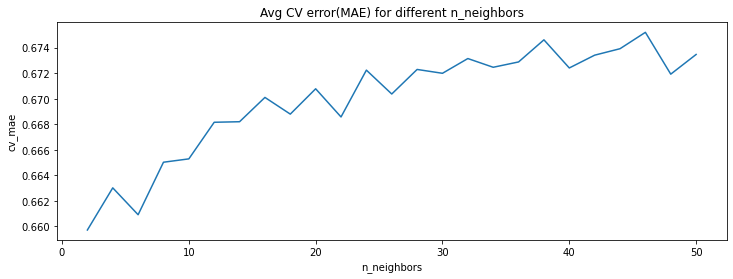

In [72]:
plot_k(mae_results, 'mae', \
       text = "Plotting average cross validation error(MAE) for different number of neighbors with MF with bias:", \
      x_label = 'n_neighbors', y_label = 'cv_mae', title = 'Avg CV error(MAE) for different n_neighbors', \
      name = '10B')

min_mae = min(mae_results.values())
key = [key for key in mae_results if mae_results[key] == min_mae]
  
print("Minimum MAE is: ", str(min_mae), 'achieved at k = ', str(key))

**B:**

The RMSE and MAE plots above suggest that optimal value for number of latent factors is 2.

In [73]:
best_k = 2

In [74]:
min_rmse = min(rmse_results.values())
key = [key for key in rmse_results if rmse_results[key] == min_rmse]
print("Minimum RMSE is: ", str(min_rmse), 'achieved at k = ', str(key))

Minimum RMSE is:  0.8630939144585111 achieved at k =  [2]


In [75]:
min_mae = min(mae_results.values())
key = [key for key in mae_results if mae_results[key] == min_mae]
print("Minimum MAE is: ", str(min_mae), 'achieved at k = ', str(key))

Minimum MAE is:  0.6597127848546552 achieved at k =  [2]


In [76]:
print("Value for RMSE at best_k = ", best_k," is: ", rmse_results[best_k])

Value for RMSE at best_k =  2  is:  0.8630939144585111


In [77]:
print("Value for MAE at best_k = ", best_k," is: ", mae_results[best_k])

Value for MAE at best_k =  2  is:  0.6597127848546552


**C: Performance on trimmed test sets** 

In [78]:
start_time = time.time()

cv = 10
kf = KFold(n_splits=cv, random_state = 42)

sim_options = {'name': 'pearson'}

rmse_pop_trim_results = {}
rmse_unpop_trim_results = {}
rmse_var_trim_results = {}
# test set is a list of tuples of the form (userid, movieid, rating)

# can we make this more efficient
for k in range(2, 51, 2):
    algo = SVD(n_factors = k, n_epochs=50, random_state=42)
    rmse_pop_trim_k = 0
    rmse_unpop_trim_k = 0
    rmse_var_trim_k = 0
    for trainset, testset in kf.split(data):   
        algo.fit(trainset)
        
        # popular movie trimming
        testset_pop_movie_trim = [test for test in testset \
                                  if test[1] not in unpopular_movies]
        predictions_pop_movies = algo.test(testset_pop_movie_trim)
        rmse_pop_trim_k = rmse_pop_trim_k + accuracy.rmse(predictions_pop_movies, verbose = False)
        
        # unpopular movie trimming
        testset_unpop_movie_trim = [test for test in testset \
                                  if test[1] in unpopular_movies]
        predictions_unpop_movies = algo.test(testset_unpop_movie_trim)
        rmse_unpop_trim_k = rmse_unpop_trim_k + accuracy.rmse(predictions_unpop_movies, verbose = False)
        
        # high var trimming
        testset_high_var_trim = [test for test in testset \
                                  if test[1] in var_trim]
        predictions_high_var_trim = algo.test(testset_high_var_trim)
        rmse_var_trim_k = rmse_var_trim_k + accuracy.rmse(predictions_high_var_trim, verbose = False)
        
        
    rmse_pop_trim_results[k] = rmse_pop_trim_k/cv
    rmse_unpop_trim_results[k] = rmse_unpop_trim_k/cv
    rmse_var_trim_results[k] = rmse_var_trim_k/cv
        
print("done in %0.3fs." % (time.time() - start_time)) 

done in 1739.953s.


For popular movie trimming in testset:
Plotting average cross validation error(RMSE) for different number of neighbors with MF_bias with popular movie trimming:
Minimum RMSE is:  0.8614188340441604 achieved at k =  [2]


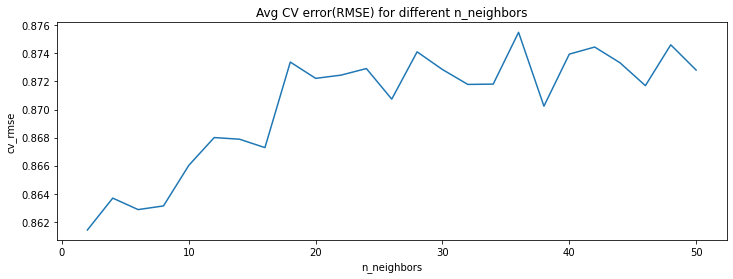

In [79]:
print("For popular movie trimming in testset:")
plot_k(rmse_pop_trim_results, 'rmse', \
       text = "Plotting average cross validation error(RMSE) for different number of neighbors with MF_bias with popular movie trimming:", \
      x_label = 'n_neighbors', y_label = 'cv_rmse', title = 'Avg CV error(RMSE) for different n_neighbors', \
      name = '10C')

min_rmse = min(rmse_pop_trim_results.values())
key = [key for key in rmse_pop_trim_results if rmse_pop_trim_results[key] == min_rmse]
  
print("Minimum RMSE is: ", str(min_rmse), 'achieved at k = ', str(key))


Plotting average cross validation error(RMSE) for different number of neighbors with MF_bias with unpopular movie trimming:
Minimum RMSE is:  0.9691277477882236 achieved at k =  [38]


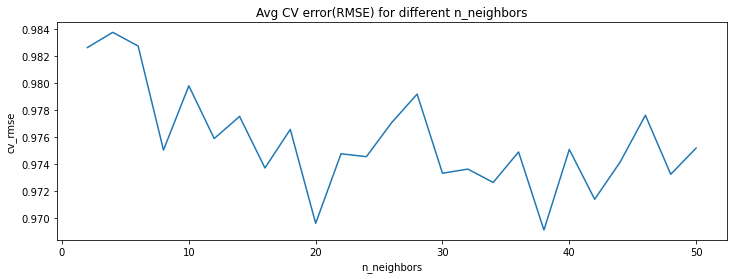

In [80]:
plot_k(rmse_unpop_trim_results, 'rmse', \
       text = "Plotting average cross validation error(RMSE) for different number of neighbors with MF_bias with unpopular movie trimming:", \
      x_label = 'n_neighbors', y_label = 'cv_rmse', title = 'Avg CV error(RMSE) for different n_neighbors', \
      name = '10D')

min_rmse = min(rmse_unpop_trim_results.values())
key = [key for key in rmse_unpop_trim_results if rmse_unpop_trim_results[key] == min_rmse]
  
print("Minimum RMSE is: ", str(min_rmse), 'achieved at k = ', str(key))

Plotting average cross validation error(RMSE) for different number of neighbors with MF_bias with high variance movie trimming:
Minimum RMSE is:  1.3420497576191912 achieved at k =  [20]


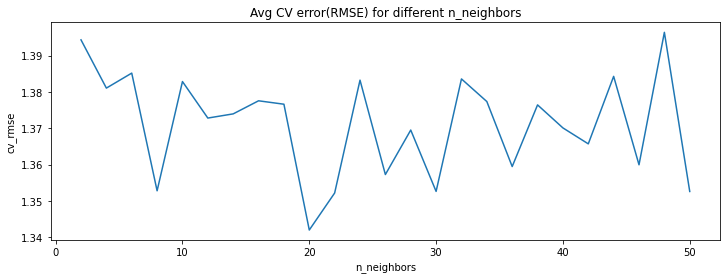

In [81]:
plot_k(rmse_var_trim_results, 'rmse', \
       text = "Plotting average cross validation error(RMSE) for different number of neighbors with MF_bias with high variance movie trimming:", \
      x_label = 'n_neighbors', y_label = 'cv_rmse', title = 'Avg CV error(RMSE) for different n_neighbors', \
      name = '10E')

min_rmse = min(rmse_var_trim_results.values())
key = [key for key in rmse_var_trim_results if rmse_var_trim_results[key] == min_rmse]
  
print("Minimum RMSE is: ", str(min_rmse), 'achieved at k = ', str(key))



#### roc curve 

In [82]:
threshold_list = [2.5,3,3.5,4]

trainset, testset = train_test_split(data, test_size=0.1, random_state=0)
algo = SVD(n_factors = best_k, n_epochs=50,  random_state=42)
algo.fit(trainset)

For no trimming: 


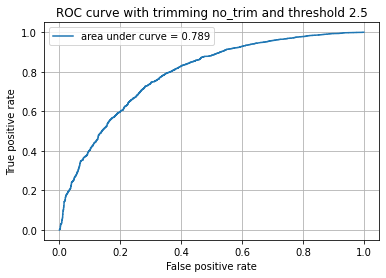

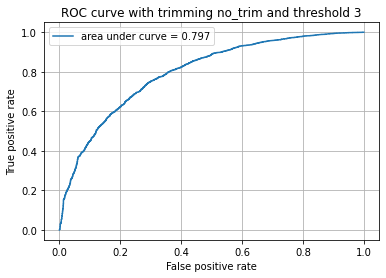

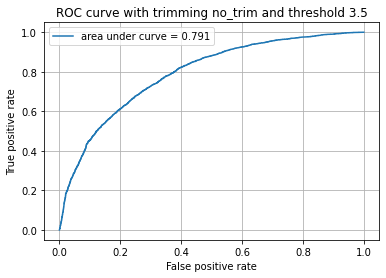

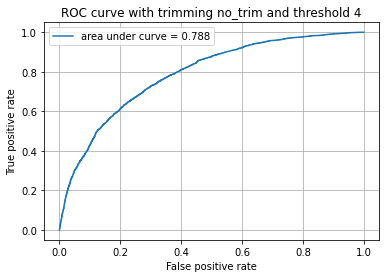

In [83]:
print("For no trimming: ")
predictions = algo.test(testset)
roc_plots(predictions, threshold_list, '10F_roc_no_trim_', 'no_trim')

For popular movie trimming in testset:


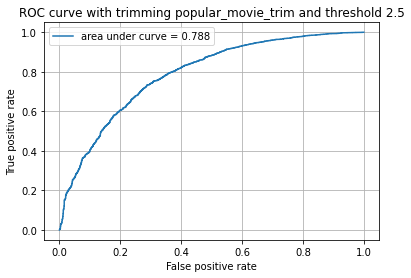

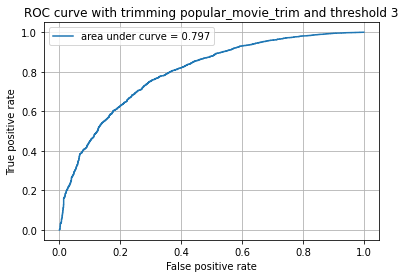

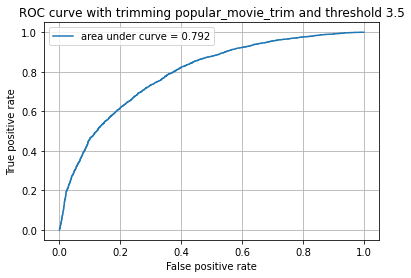

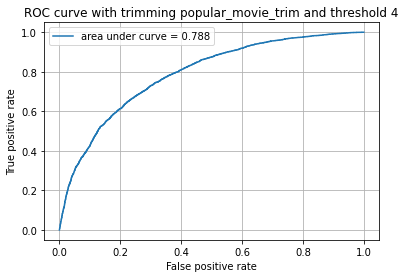

In [84]:
print("For popular movie trimming in testset:")
testset_pop_movie_trim = [test for test in testset \
                                  if test[1] not in unpopular_movies]

predictions = algo.test(testset_pop_movie_trim)
roc_plots(predictions, threshold_list, '10F_roc_pop_trim_', 'popular_movie_trim')

For unpopular movie trimming in testset:


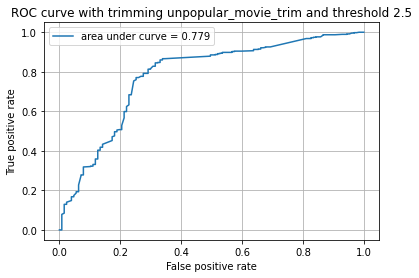

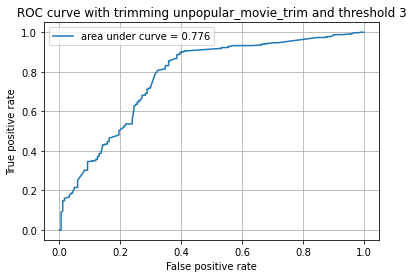

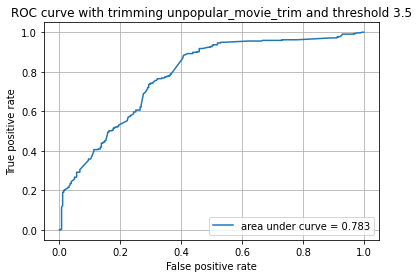

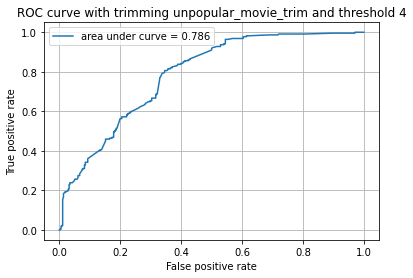

In [85]:
print("For unpopular movie trimming in testset:")
testset_unpop_movie_trim = [test for test in testset \
                                  if test[1] in unpopular_movies]

predictions = algo.test(testset_unpop_movie_trim)
roc_plots(predictions, threshold_list, '10F_roc_unpop_trim_', 'unpopular_movie_trim')

For high variance movie trimming in testset:


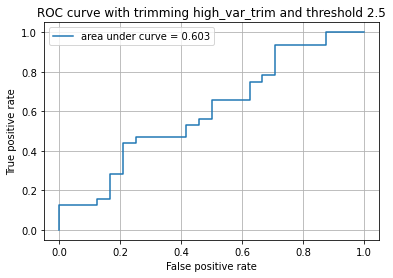

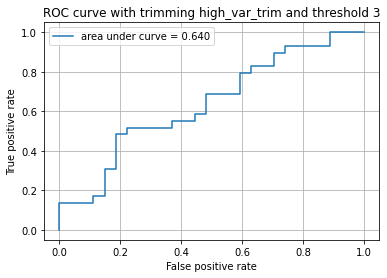

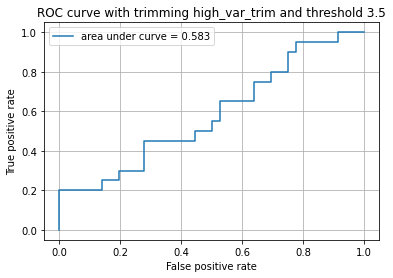

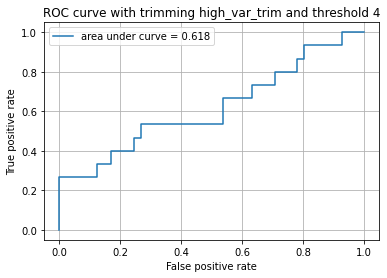

In [86]:
print("For high variance movie trimming in testset:")
testset_high_var_trim = [test for test in testset \
                                  if test[1] in var_trim]

predictions = algo.test(testset_high_var_trim)
roc_plots(predictions, threshold_list, '10F_roc_high_var_trim_', 'high_var_trim')

### QUESTION 11

In [87]:
user_naive_prediction = ratings.groupby(['userId'])['rating'].mean().reset_index(name = 'avg_rating')

In [88]:
print(user_naive_prediction.head())

   userId  avg_rating
0       1    4.368534
1       2    3.948276
2       3    2.435897
3       4    3.555556
4       5    3.636364


In [89]:
def get_test_prediction_and_rmse (testset, user_naive_prediction):
    
    test_df = pd.DataFrame({'test_data': testset})
    test_df[['userId', 'movieId', 'rating']] = pd.DataFrame(test_df['test_data'].tolist(), index=test_df.index)
    test_df = test_df.drop(['test_data'], axis = 1)
    
    test_df = pd.merge(test_df, user_naive_prediction, how = 'left', on = 'userId')
    test_df['sq_error'] = test_df.apply(lambda row: (row['avg_rating'] - row['rating'])**2, axis=1)
    rmse = (sum(test_df['sq_error'])/test_df.shape[0])**0.5
    pred_ratings = list(test_df['avg_rating'])
    
    return pred_ratings, rmse
    

In [90]:
start_time = time.time()

rmse = 0

for trainset, testset in kf.split(data):
    prediction, rmse_tmp = get_test_prediction_and_rmse(testset, user_naive_prediction)
    rmse = rmse + rmse_tmp
avg_rmse = rmse / cv
print("Average RMSE on validation set for naive collaborative filter is: {}".format(avg_rmse))


Average RMSE on validation set for naive collaborative filter is: 0.9347022719742941


In [91]:
rmse_pop_trim = 0
rmse_unpop_trim = 0
rmse_high_var_trim = 0
for trainset, testset in kf.split(data):   
        
    # popular movie trimming
    testset_pop_movie_trim = [test for test in testset \
                                  if test[1] not in unpopular_movies]
    predictions_pop_movies, rmse_pop_trim_tmp = get_test_prediction_and_rmse(testset_pop_movie_trim, user_naive_prediction)
    rmse_pop_trim = rmse_pop_trim + rmse_pop_trim_tmp
    
    # unpopular movie trimming
    testset_unpop_movie_trim = [test for test in testset \
                                  if test[1] in unpopular_movies]
    predictions_unpop_movies, rmse_unpop_trim_tmp = get_test_prediction_and_rmse(testset_unpop_movie_trim, user_naive_prediction)
    rmse_unpop_trim = rmse_unpop_trim + rmse_unpop_trim_tmp
    
    # high var trimming
    testset_high_var_trim = [test for test in testset \
                                  if test[1] in var_trim]
    predictions_high_var_trim, rmse_high_var_trim_tmp = get_test_prediction_and_rmse(testset_high_var_trim, user_naive_prediction)
    rmse_high_var_trim = rmse_high_var_trim + rmse_high_var_trim_tmp


avg_rmse_pop_trim = rmse_pop_trim/cv 
avg_rmse_unpop_trim = rmse_unpop_trim/cv
avg_rmse_high_var_trim = rmse_high_var_trim/cv
        
print("Average RMSE on test set with popular movie trimming for naive collaborative filter is: {}".format(avg_rmse_pop_trim))
print("Average RMSE on test set with unpopular movie trimming for naive collaborative filter is: {}".format(avg_rmse_unpop_trim))
print("Average RMSE on test set with high variance movie trimming for naive collaborative filter is: {}".format(avg_rmse_high_var_trim))



Average RMSE on test set with popular movie trimming for naive collaborative filter is: 0.9323153859918841
Average RMSE on test set with unpopular movie trimming for naive collaborative filter is: 0.9704428317468249
Average RMSE on test set with high variance movie trimming for naive collaborative filter is: 1.3760778528858921


### QUESTION 12

In [92]:
threshold = 3

trainset, testset = train_test_split(data, test_size=0.1, random_state=0)
algo_list = [KNNWithMeans(k=20, sim_options = {'name':'pearson'}, random_state = 42), NMF(n_factors = 20, random_state = 42), \
        SVD(n_factors = 2, n_epochs=50, random_state = 42)]

fpr_list = []
tpr_list = []
auc_list = []
for algo in algo_list:
    algo.fit(trainset)
    predictions = algo.test(testset)
    pred = np.array([p.est for p in predictions])
    actual = np.array([p.r_ui for p in predictions])

    y_pred = pred
    y_act = actual>=threshold
    fpr, tpr, _ = roc_curve(y_act, y_pred)
    roc_auc = auc(fpr, tpr)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(roc_auc)
    

Computing the pearson similarity matrix...
Done computing similarity matrix.


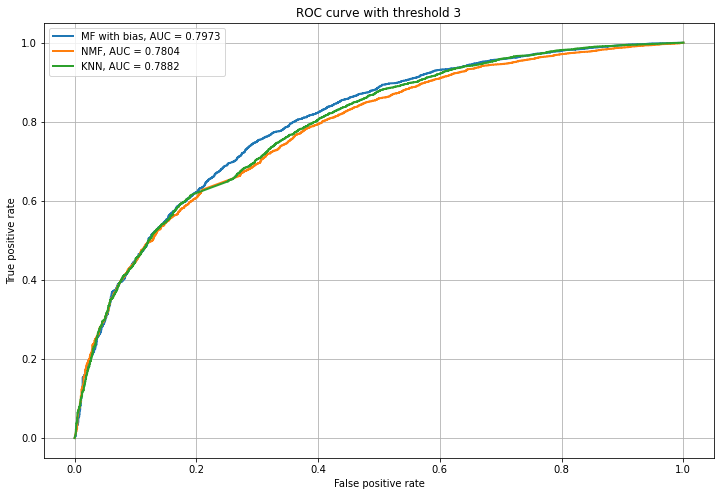

In [93]:
plt.figure(figsize=(12,8))
plt.plot(fpr_list[2], tpr_list[2], lw=2, label='MF with bias, AUC = %0.4f' %auc_list[2])
plt.plot(fpr_list[1], tpr_list[1], lw=2, label='NMF, AUC = %0.4f' %auc_list[1])
plt.plot(fpr_list[0], tpr_list[0], lw=2, label='KNN, AUC = %0.4f' %auc_list[0])

plt.title('ROC curve with threshold '+str(threshold))
plt.xlabel('False positive rate',fontsize=10)
plt.ylabel('True positive rate',fontsize=10)
plt.grid()
plt.legend()
plt.savefig('./plots_lib/12.png')


Matrix factorization with bias performs best in terms of AUC of the model for prediction with threshold = 3. It is followed by KNN and then by NMF. The AUC values are close for the three methods. This suggests that all the models should have similar predictive power. This is also suggested by the similar error metrics for the three models. <br>

### QUESTION 13 <br>

**Meaning of precision:** Precision in the context of recommendation is the number of items suggested by the ranking which were actually liked by the user out of total number of items suggested. If we think of making a suggestion to a movie as a predicted positive and user actually liking the movie as a true positive. Then, a parallel can be drawn to the precision for a binary classification. In the formula, $S(t)$ is the set of top items suggested where $t$ is the number of items suggested by the ranking algorithm, $G$ is the set of items actually liked by the user. The intersection of the 2 sets gives the set of items suggested by the ranking which were actually liked by the user. We take the ratio of such items (parallel to true positives) to the total number of items suggested (predicted positives). <br>

**Meaning of recall:** Recall is the ratio of how many were actually predicted positive by the model out of total true positives. So, here we take the total number of items suggested by the ranking algorithm which were actually liked by the user $|S(t) \cap G|$ and take the ratio with respect to total number of items liked by the user $|G|$. <br>


### QUESTION 14

In [94]:
def get_precision_recall (predictions, k_list =[1,5,10], thres = 3):
    users = []
    items = []
    actual_rating = []
    predicted_rating = []
    for el in predictions:
        users.append(el.uid)
        items.append(el.iid)
        actual_rating.append(el.r_ui)
        predicted_rating.append(el.est)
        
    predictions_df = pd.DataFrame({'user': users, 'item': items, \
                                   'actual_rating': actual_rating, 'pred_rating': predicted_rating})
    
    # use threshold to obtain the set G
    thres_df = predictions_df[predictions_df['actual_rating'] >= thres]
    
    #movies in G
    ground_truth = thres_df.groupby(['user'])['item'].apply(list).reset_index(name = 'item_list')
    ground_truth['num_items_G'] = ground_truth['item_list'].apply(lambda x: len(x))
    
    # get precision and recall for all threshold
    precision = []
    recall = []
    for k in k_list:
        # keep users when they have rated more than k items with a score > 3
        users_k = list(ground_truth[ground_truth['num_items_G'] >= k]['user'])
        pred_k = predictions_df[predictions_df['user'].isin(users_k)]
        
        top_k_pred = pred_k.sort_values('pred_rating',ascending=False).groupby('user').head(k)
        suggestion_k = top_k_pred.groupby(['user'])['item'].apply(list).reset_index(name = 'suggest_list')
        suggestion_k = pd.merge(suggestion_k, ground_truth, how = 'left', on = 'user')
        suggestion_k['comm_items'] = suggestion_k.apply(lambda row: list(set(row['suggest_list']) & set(row['item_list'])), axis = 1)
        suggestion_k['precision'] = suggestion_k.apply(lambda row: len(row['comm_items'])/len(row['suggest_list']), axis = 1)
        suggestion_k['recall'] = suggestion_k.apply(lambda row: len(row['comm_items'])/len(row['item_list']), axis = 1)
        precision.append(suggestion_k['precision'].mean())  # average over users
        recall.append(suggestion_k['recall'].mean())
        
    return precision, recall
    

In [95]:
# algo = KNNWithMeans(k=20, sim_options = {'name':'pearson'}, verbose = False)
algo_list = [KNNWithMeans(k=20, sim_options = {'name':'pearson'}, verbose = False, random_state = 42), \
             NMF(n_factors = 20, random_state = 42), \
        SVD(n_factors = 4, n_epochs=50, random_state = 42)]


t = list(range(1,26))

precision_knn, precision_nmf, precision_mf_bias = [0] * len(t), [0] * len(t), [0] * len(t)
recall_knn, recall_nmf, recall_mf_bias = [0] * len(t), [0] * len(t), [0] * len(t)

for i in range(3):
    algo = algo_list[i]
    for trainset, testset in kf.split(data):
        algo.fit(trainset)
        predictions = algo.test(testset)
        precision_fold, recall_fold = get_precision_recall(predictions, t, thres = 3)
        if(i == 0):
            precision_knn = np.asarray(precision_knn) + np.asarray(precision_fold)
            recall_knn = np.asarray(recall_knn) + np.asarray(recall_fold)
        elif(i==1):
            precision_nmf = np.asarray(precision_nmf) + np.asarray(precision_fold)
            recall_nmf = np.asarray(recall_nmf) + np.asarray(recall_fold)
        elif(i==2):
            precision_mf_bias = np.asarray(precision_mf_bias) + np.asarray(precision_fold)
            recall_mf_bias = np.asarray(recall_mf_bias) + np.asarray(recall_fold)
            

knn_precision = [x/cv for x in precision_knn]  # average over cross validation sets
knn_recall = [x/cv for x in recall_knn]

nmf_precision = [x/cv for x in precision_nmf]  # average over cross validation sets
nmf_recall = [x/cv for x in recall_nmf]

mf_precision = [x/cv for x in precision_mf_bias]  # average over cross validation sets
mf_recall = [x/cv for x in recall_mf_bias]


#### Plot average precision for the three models

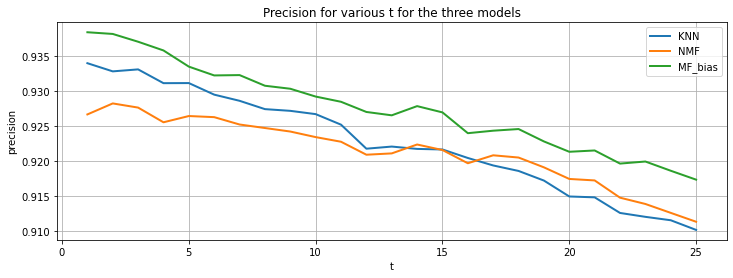

In [96]:
# plot precision 
plt.figure(figsize=(12,4))
plt.plot(t, knn_precision, lw=2, label='KNN')
plt.plot(t, nmf_precision, lw=2, label='NMF')
plt.plot(t, mf_precision, lw=2, label='MF_bias')
plt.title('Precision for various t for the three models')
plt.xlabel('t')
plt.ylabel('precision')
plt.grid()
plt.legend()
plt.savefig('./plots_lib/14A.png')

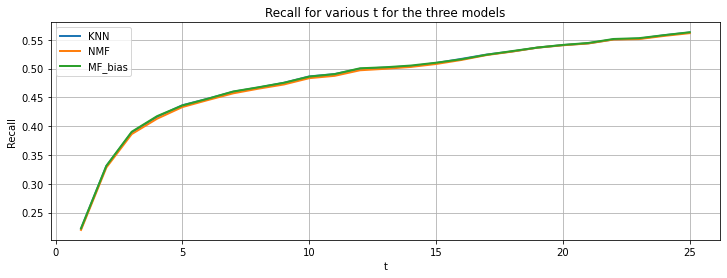

In [97]:
# plot recall
plt.figure(figsize=(12,4))
plt.plot(t, knn_recall, lw=2, label='KNN')
plt.plot(t, nmf_recall, lw=2, label='NMF')
plt.plot(t, mf_recall, lw=2, label='MF_bias')
plt.title('Recall for various t for the three models')
plt.xlabel('t')
plt.ylabel('Recall')
plt.grid()
plt.legend()
plt.savefig('./plots_lib/14B.png')

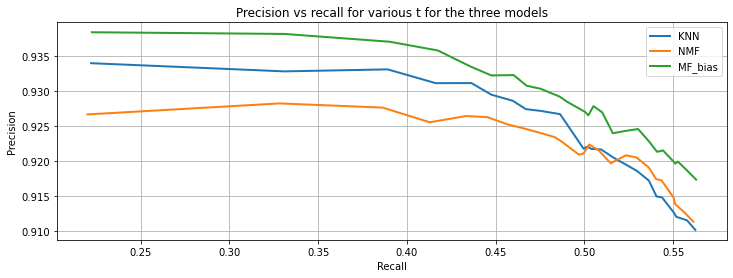

In [98]:
# plot precision against recall
plt.figure(figsize=(12,4))
plt.plot(knn_recall, knn_precision, lw=2, label='KNN')
plt.plot(nmf_recall, nmf_precision, lw=2, label='NMF')
plt.plot(mf_recall, mf_precision, lw=2, label='MF_bias')
plt.title('Precision vs recall for various t for the three models')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.legend()
plt.savefig('./plots_lib/14C.png')

In [99]:
def plot_curves (x, y, title, x_label, y_label, name):
    plt.figure(figsize=(12,4))
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid()
    plt.savefig('./plots_lib/'+name+'.png')

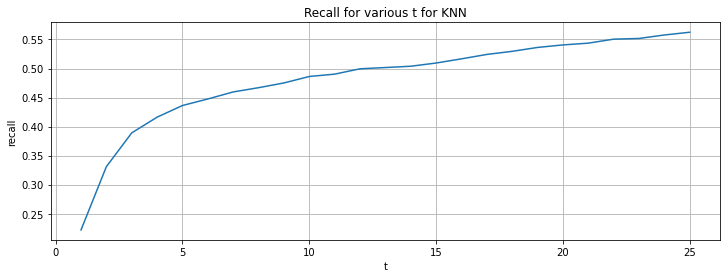

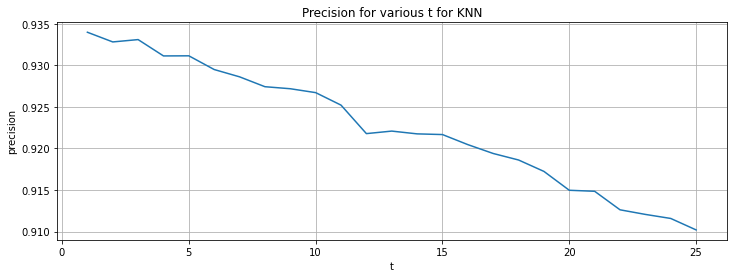

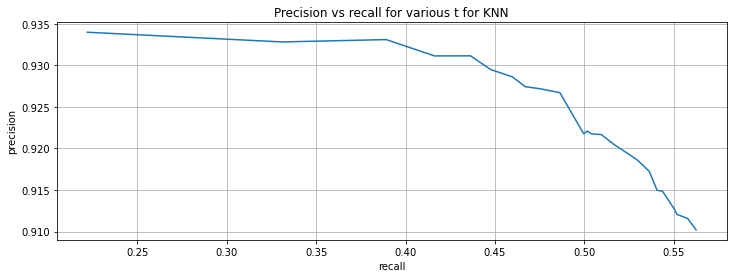

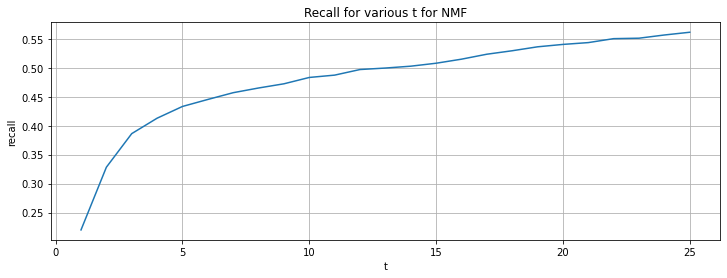

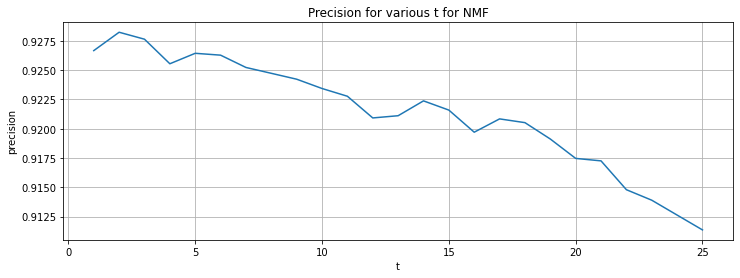

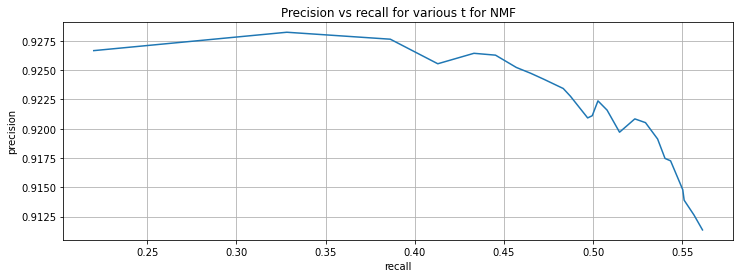

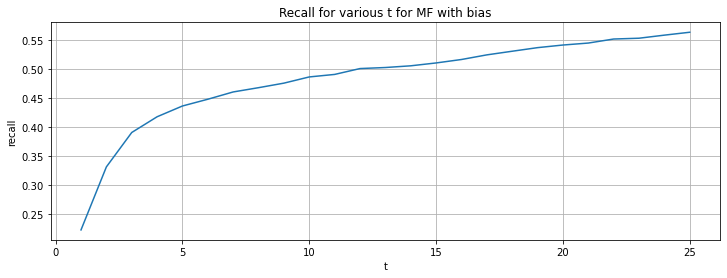

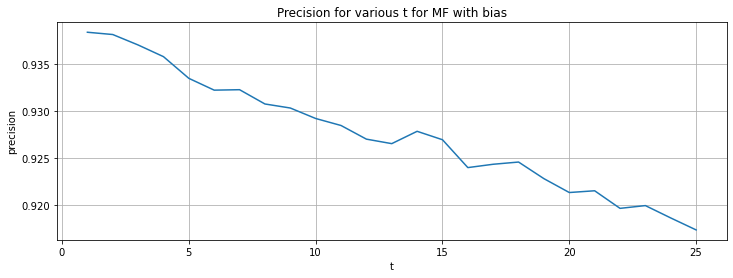

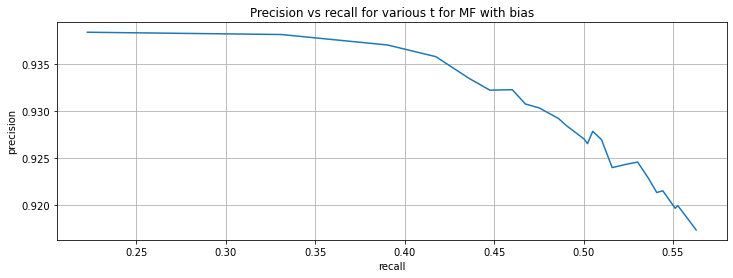

In [100]:
## KNN
plot_curves(t, knn_recall, 'Recall for various t for KNN', 't', 'recall', 'knn_recall')
plot_curves(t, knn_precision, 'Precision for various t for KNN', 't', 'precision', 'knn_precision')
plot_curves(knn_recall, knn_precision, 'Precision vs recall for various t for KNN', 'recall', 'precision', 'knn_recall_precision')

## NMF
plot_curves(t, nmf_recall, 'Recall for various t for NMF', 't', 'recall', 'nmf_recall')
plot_curves(t, nmf_precision, 'Precision for various t for NMF', 't', 'precision', 'nmf_precision')
plot_curves(nmf_recall, nmf_precision, 'Precision vs recall for various t for NMF', 'recall', 'precision', 'nmf_recall_precision')

## MF bias
plot_curves(t, mf_recall, 'Recall for various t for MF with bias', 't', 'recall', 'mf_recall')
plot_curves(t, mf_precision, 'Precision for various t for MF with bias', 't', 'precision', 'mf_precision')
plot_curves(mf_recall, mf_precision, 'Precision vs recall for various t for MF with bias', 'recall', 'precision', 'mf_recall_precision')


The precision vs t plot for all three methods are non-monotonic decreasing in t. This is because as we start to make more and more recommendations based on the ranking list, the probability/confidence that the subsequent element would also be a good suggestion declines. However, since both numerator and denominator is a function of t, the decline is not monotonic. <br> 

The recall curve has an increasing trend for all three methods. This is because if we expand the list of suggestions it is more likely to capture more elements from the ground truth set. <br>

The precision vs recall curve is non-monotonic decreasing in all the three methods, this is because precision wrt t is non-monotonic. In general, if we try to recall more items from the ground truth, we have to expand the list of suggestions and by expanding the list we may end up with low precision because the new/expanded set of suggestions might not be good enough. <br>

**Relevance of recommendation list:** For each value of recall MF with bias outperforms the other two methods in terms of precision. Hence, the list of suggestions is most relevant for the MF with bias model. This is followed by KNN and then by NMF. However, for higher recall values, we start to see the trend reverse. 

#### EXTRAS

### Custom implementation of KNN

In [101]:
def get_pearson_correlation_matrix (trainset):
    
    pearson = {}
    usr_mean_dict = {}
    usr_rating_dict = {}
    user_movie_dict = {}
    
    for i in range(trainset.n_users):
        list_movies , list_ratings = zip(*trainset.ur[i])
        usr_mean_dict[i] = np.mean(list_ratings)
        usr_rating_dict[i] = dict(trainset.ur[i])
        user_movie_dict[i] = list_movies
        
    for i in range(trainset.n_users):
        usr1_movies = user_movie_dict[i]
        for j in range(i+1, trainset.n_users):
            usr2_movies = user_movie_dict[j]
            com_movies = list(set(usr1_movies) & set(usr2_movies))
            
            # if no movie in common
            if(len(com_movies) == 0):
                pearson.setdefault(i, {})[j] = 0
                pearson.setdefault(j, {})[i] = 0
                continue
            
            else:
                r1 = [(usr_rating_dict[i][mov]-usr_mean_dict[i]) for mov in com_movies]
                r2 = [(usr_rating_dict[j][mov]-usr_mean_dict[j]) for mov in com_movies]
            
                den1 = np.linalg.norm(r1)
                den2 = np.linalg.norm(r2)
            
                if(den1 > 0 and den2 > 0):
                    coeff = np.dot(r1, r2)/(den1*den2)
                else:
                    coeff = 0
                    
                pearson.setdefault(i, {})[j] = coeff
                pearson.setdefault(j, {})[i] = coeff
            
    return pearson, usr_mean_dict, usr_rating_dict


In [102]:
def knn_pred (testset, pearson, usr_mean_dict, usr_rating_dict, k=10):
    '''
    Given a user and a similarity dictionary, return its nearest neighbors in the inner uid space.
    Note: inner uid and raw uid are different in trainset
    usr from the testset is the raw user id
    '''
    
    pred = {}
    for usr, item, rating in testset:
        i_usr = trainset.to_inner_uid(usr)
        base_usr_rating = usr_mean_dict[i_usr]
        
        try:
            i_item = trainset.to_inner_iid(item)
            all_neighbor = pearson[i_usr]
            sort_neighbor = dict(sorted(all_neighbor.items(), key=lambda item: item[1], reverse = True))
            
            num1 = []
            num2 = []
            den = []
            
            n_count = 0
            for n, v in sort_neighbor.items():
                if(n_count == k):
#                     print(n_count)
                    break
                
                if(i_item in usr_rating_dict[n].keys()):
#                     print('loop entered')
                    num1.append(v)
#                     print(num1)
                    num2.append(usr_rating_dict[n][i_item] - usr_mean_dict[n])
#                     print(num2)
                    den.append(abs(v))
#                     print(n_count)
                    n_count +=1
                    
            den_v = sum(den)
            if(den_v > 0):
                pred_rating = base_usr_rating+ (np.dot(num1, num2)/den_v)
                pred[(usr, item, rating)] = (rating, pred_rating)
            else:
                pred[(usr, item, rating)] = (rating, base_usr_rating)
        except:
            pred[(usr, item, rating)] = (rating, base_usr_rating)
    return pred

In [103]:
## cross-validate on 10 folds and compare results

# reader = Reader()
# data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# cv = 10
# sim_options = {'name': 'pearson_baseline'}
# kf = KFold(n_splits=cv)

In [104]:
# start_time = time.time()
# rmse_lib = {}
# rmse_man = {}
# mae_lib = {}
# mae_man = {}

# for k in range(2, 101, 2):
#     rmse_lib[k] = 0
#     rmse_man[k] = 0
#     mae_lib[k] = 0
#     mae_man[k] = 0
    
# counter = 1
# for trainset, testset in kf.split(data): 
#     print("training for fold = ", counter)
#     counter += 1
#     pearson, usr_mean_dict, usr_rating_dict = get_pearson_correlation_matrix(trainset)
#     for k in range(2, 101, 2):
        
#         algo = KNNWithMeans(k = k, sim_options=sim_options, verbose = False)
#         algo.fit(trainset)
#         lib_pred = algo.test(testset)
#         man_pred = knn_pred(testset, pearson, usr_mean_dict, usr_rating_dict, k)
        
#         rmse_lib[k] += accuracy.rmse(lib_pred, verbose = False)
#         mae_lib[k] += accuracy.mae(lib_pred, verbose = False)
        
#         v = list(man_pred.values())
#         act , pred = zip(*v)
#         act = np.asarray(act)
#         pred = np.asarray(pred)
        
#         rmse_man[k] += np.linalg.norm(pred - act) / np.sqrt(len(act))
#         mae_man[k] += np.sum(abs(pred - act)) / len(act)
#     print("done in %0.3fs." % (time.time() - start_time)) 

# for k in range(2, 101, 2):
#     rmse_lib[k] = rmse_lib[k] / cv
#     rmse_man[k] = rmse_man[k] / cv
#     mae_lib[k] = mae_lib[k] / cv
#     mae_man[k] = mae_man[k] / cv
        
# print("done in %0.3fs." % (time.time() - start_time)) 

In [105]:
# start_time = time.time()

# rmse_pop_trim_results = {}
# rmse_unpop_trim_results = {}
# rmse_var_trim_results = {}
# # test set is a list of tuples of the form (userid, movieid, rating)

# # can we make this more efficient
# for k in range(2, 20, 2):
#     algo = KNNWithMeans(k=k, sim_options=sim_options, verbose = False, random_state = 0)
#     rmse_pop_trim_k = 0
#     rmse_unpop_trim_k = 0
#     rmse_var_trim_k = 0
#     for trainset, testset in kf.split(data):   
#         algo.fit(trainset)
#         usr_mean_dict = {}
#         for i in range(trainset.n_users):
#             list_movies , list_ratings = zip(*trainset.ur[i])
#             usr_mean_dict[i] = np.mean(list_ratings)
        
#         # popular movie trimming
#         testset_pop_movie_trim = [test for test in testset \
#                                   if test[1] not in unpopular_movies]
        
#         predictions_pop_movies = algo.test(testset_pop_movie_trim)
#         rmse_pop_trim_k = rmse_pop_trim_k + accuracy.rmse(predictions_pop_movies, verbose = False)
        
#         # unpopular movie trimming
#         testset_unpop_movie_trim = [test for test in testset \
#                                   if test[1] in unpopular_movies]
        

#         predictions_unpop_movies = algo.test(testset_unpop_movie_trim)
#         predictions_unpop_movies = change_was_impossible_pred(predictions_unpop_movies, usr_mean_dict, trainset)
#         rmse_unpop_trim_k = rmse_unpop_trim_k + accuracy.rmse(predictions_unpop_movies, verbose = False)

        
#         # high var trimming
#         testset_high_var_trim = [test for test in testset \
#                                   if test[1] in var_trim]
#         predictions_high_var_trim = algo.test(testset_high_var_trim)
#         rmse_var_trim_k = rmse_var_trim_k + accuracy.rmse(predictions_high_var_trim, verbose = False)
        
        
#     rmse_pop_trim_results[k] = rmse_pop_trim_k/cv
#     rmse_unpop_trim_results[k] = rmse_unpop_trim_k/cv
#     rmse_var_trim_results[k] = rmse_var_trim_k/cv
        
# print("done in %0.3fs." % (time.time() - start_time)) 

In [106]:
def validate_pearson (usr1, usr2, ratings):
    '''
    Given usr1 and usr2 from trainset similarity matrix, calculate pearson correlation 
    using raw data to validate the calculations in the function
    '''
    r_usr1 = trainset.to_raw_uid(usr1)
    r_usr2 = trainset.to_raw_uid(usr2)
    
    print('user 1 in raw ratings dataset is: ', r_usr1, 'user 2 in raw ratings dataset is: ', r_usr2)
    
    movies_usr1 = [ i[0] for i in trainset.ur[usr1]]
    r_movies_usr1 = [trainset.to_raw_iid(x) for x in movies_usr1]
    
    movies_usr2 = [ i[0] for i in trainset.ur[usr2]]
    r_movies_usr2 = [trainset.to_raw_iid(x) for x in movies_usr2]
    
    common_mov = list(set(r_movies_usr1) & set(r_movies_usr2))
    print('List of common movies: ', common_mov)
    
    mean_usr1_sub = sum(ratings[(ratings['userId'] == r_usr1) & \
                                (ratings['movieId'].isin(common_mov))]['rating'])/len(common_mov)
    mean_usr2_sub = sum(ratings[(ratings['userId'] == r_usr2) & \
                                (ratings['movieId'].isin(common_mov))]['rating'])/len(common_mov)
    
    mean_usr1_glo = sum(ratings[(ratings['userId'] == r_usr1) & \
                                (ratings['movieId'].isin(r_movies_usr1))]['rating'])/len(r_movies_usr1)
    mean_usr2_glo = sum(ratings[(ratings['userId'] == r_usr2) & \
                                (ratings['movieId'].isin(r_movies_usr2))]['rating'])/len(r_movies_usr2)
    
    print('global mean for user 1 is: ', mean_usr1_glo, 'and global mean for user 2 is:', mean_usr2_glo)
    print('subset mean for user 1 is: ', mean_usr1_sub, 'and subset mean for user 2 is:', mean_usr2_sub)
    
    num, den1, den2 = 0, 0, 0
    num_g, den1_g, den2_g = 0,0,0
    for mov in common_mov:
        
        usr1_rating = list(ratings[(ratings['userId'] == r_usr1) & (ratings['movieId'] == mov)]['rating'])[0]
        usr2_rating = list(ratings[(ratings['userId'] == r_usr2) & (ratings['movieId'] == mov)]['rating'])[0]
        
        usr1_m_rating_sub = usr1_rating - mean_usr1_sub
        usr2_m_rating_sub = usr2_rating - mean_usr2_sub
        
        usr1_m_rating_glo = usr1_rating - mean_usr1_glo
        usr2_m_rating_glo = usr2_rating - mean_usr2_glo

        num = num + (usr1_m_rating_sub*usr2_m_rating_sub)
        num_g = num_g + (usr1_m_rating_glo*usr2_m_rating_glo)
        
        den1 = den1 + (usr1_m_rating_sub)**2
        den2 = den2 + (usr2_m_rating_sub)**2
        den1_g = den1_g + (usr1_m_rating_glo)**2
        den2_g = den2_g + (usr2_m_rating_glo)**2
        
    sub = (num/((den1**0.5)*(den2**0.5)))
    glo = (num_g/((den1_g**0.5)*(den2_g**0.5)))
    
    return sub, glo